# Task 5 - Grafici - :


Calcolo, sui run BOTTINO dello scenario ssp585 + pi-control, dell'
   1) indice 3.4 di ENSO sugli ultimi 150 del rum --> plot 1,
   2) Standard Deviation:
      - Scatter plot delle STD totale + ultimi 100 anni --> plot 3,
      - Violin plot della STD_RM (per i bottini: ultimi 500 anni) --> plot 4,
   3) Power spectra (BOTTINI + pi-control):
      - Spettro e Running mean dello stesso a 20 e 50 elementi + subplot contenente tutti gli spettri --> plot 5,
      - Stessa cosa ma con la stessa scala per tutti i subplot --> plot 5-bis,
      - Confronto diretto tra tutti gli spettri --> plot 5-tris,
      - Spettro su cui è stata eseguita una Running mean su 20 e 50 elementi --> plot 5-quadris,
      - Stessa cosa del punto precedente ma con il range delle ascisse esteso --> plot 5-quadris-bis
   4) Recap delle statistiche principali sui parametri delle grandezze analizzate

Note:
- l'indice è calcolato attraverso la running mean su 30 anni come metodo di detrending storico, senza tagliare testa e code.
- la finestra temporale in cui si visualizza l'indice ridotto è di 150 anni
- la finestra temporale in cui si ricalcola la STD è di 100 anni (ovviamente oltre a quella totale)
- la running mean sulla STD è di 30 anni

___

## TASK 5b:
   
   I punti 2) e 3) nei grafici 4 e 5 (violin plot e Power Spectra) sono stati ripetuti per i dataset dello Storico e dell'Osservato.
   (Task 5b ha compreso anche l'aggiunta del pi-control ai run BOTTINO)

### Versione aggiornata:

Cosa cambia:
     
- Vecchio calcolo dell'indice Nino3.4:
```python
# Rimozione del trend storico attraverso la Running Mean sui precedenti 30 anni
RM = SST34.rolling(time=360, center=True).mean().dropna("time") # Running Mean 360 months
RMTrend = (RM.groupby('time.month')-RM.groupby('time.month').mean('time')).mean('lat').mean('lon')
SST34_DetrendedRM = SST34 - RMTrend
# Rimozione del ciclo stagionale
### Anomaly
Anom_meanMonthRM = (SST34_DetrendedRM.groupby('time.month') - 
               SST34_DetrendedRM.groupby('time.month').mean('time'))
### Ninõ Index
Index_MonthRM = Anom_meanMonthRM.mean('lat').mean('lon') # Mensile, no Trend storico, no SC
```

-  Nuovo calcolo dell'indice Nino3.4:
```python
# Rimozione del trend storico attraverso la Running Mean sui precedenti 30 anni
RM = SST34.rolling(time=360, min_periods=1, center=True).mean().dropna("time") # Running Mean 360 months
SST34_DetrendedRM = SST34 - RM
# Rimozione del ciclo stagionale
# Anomaly
Anom_meanMonthRM = (SST34_DetrendedRM.groupby('time.month') - 
               SST34_DetrendedRM.groupby('time.month').mean('time'))
# # Media spaziale: Ninõ Index
Index_MonthRM = global_mean(Anom_meanMonthRM)  # Mensile, no Trend storico, no SC
                                                      # equivalente a .mean('lat').mean('lon') ma pesa la media sulle lat con il cos della lat
```

### Differenze

Le differenze della vecchia versione (portata in tesi) e questa rivista e corretta sono le seguenti:
   - è stata corretta la definizione secondo la quele viene calcolato l'indice Nino 3.4, ora oltre l'anomalia di temperatura è considerato anche la persistenza temprale per l'anomalia che deve essere di 5 mesi per definirsi un evento di nino.
   - per tutti i dataset è stato utilizzato l'intero range temporale disponibile, prima tagliato di 15 ai margini (inizio e fine) dell'intervallo temporale, quindi ridotto e statisticamente più debole. Questo ha effetti rilevenati per Hist e Obs il cui range iniziale è: Hist: 1850-2015; Obs: 1870-2020, ridotto rispettivamente a 1865-2000 e 1885-2005, uniformato a 1885-2000 per il calcolo dell'indice ridotto ulteriormente al 1910-01-01-1975-01-01 per il calcolo della STD_RM che aveva una RM di 50 anni. Range inalterato per quanto riguarda il power spectra.
   - Per la rimozione del trand storico: nella running mean "RM" è stato introdotto il parametro min_periods=1 (default window/2), non viene più eseguito il passaggio ridondante del calcolo del trend: RMTrend = (RM.groupby('time.month')-RM.groupby('time.month').mean('time')).mean('lat').mean('lon')
   ma RM viene sottratto direttamente alla SST34.
   - Il calcolo dell'indice dall'anomalia come media spaziale sul box Nino3.4 non passa più dalle medie lat lon di xarray ma dalla media di fede "global_mean" che tiene conto del cos(\theta) con la latitudine (errore commesso: infinitesimo)
   - Standard deviations: la finestra della running mean è stata ridotta a 30 anni (stessa che per il metodo di detrending storico nell'indice del punto sopra) invece che 50, con min_periods=1 per evitare perdita di testa e coda, specialmente per hist e obs.
   - power spectra: non cambia nulla.

In [1]:
# Pre-computazione std_RM
def preprocess_std_RM(var):
    if len(var) < 500*12:
        var.compute()
    else:
        var.isel(time=slice(500*12, None)).compute()
    return var

In [1]:
# Definizione ampiezza
def forced_damped_oscillator(x, A, x0, gamma):
    return A / np.sqrt((x**2 - x0**2)**2 + (2 * gamma * x)**2)
"""
- A: Ampiezza del picco.
- x_0: Frequenza di risonanza.
- \gamma: Smorzamento (larghezza del picco).
- x: Variabile indipendente (frequenza, ad esempio).
- y(x): Risposta del sistema.
Analogia con il circuito elettrico RCL serie: vedere Mazzoldi vol 2 pg 371-373
    - A = \epsilon_0 (la fem)
    - x = \omega*L
    - x0 = 1/(\omega*C) (frequenza propria del sistema)
    - gamma = R/2*\omega*L (-->2*gamma*x = R)
Analogia con il sistema meccanico: massa attaccata ad una molla con attrito e forzante: vedere doc 7 - moti oscillatori con attrito, fisica generale 1B Anna Franchini
    m* d^2x/dt^2 = -b* dx/dt -kx (k=cost. elastica, b = cost. attrito)
    - A = F/m
    - x = \Omega
    - x0 = \omega_0
    - gamma = \beta = b/2m
"""
def damped_oscillator(A, t, gamma):
    return A * np.exp((-1)*gamma*t)


In [ ]:
# import libraries
import numpy as np
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
from cftime import date2num
from sklearn.metrics import mean_squared_error # Per il fit parabolico
from scipy.optimize import curve_fit # Per il fit dell'oscillatore armonico smorzato
import climtools_lib as ctl

common_dir_proj = '/home/montanarini/ELNINO/'
Dir_outputs_var = 'output/Task-5_NinoIndex/Variables/'
Dir_output_plot = 'output/Task-5_NinoIndex/Variables_Plot/'
Dir_images = 'images/Task-5_NinoIndex/'

# BOTTINOs list and dictionary
dataset_names = ['b990', 'b025', 'b050', 'b065', 'b080', 'b100', 'pi-control', 'hist', 'obs']
datasets = {}  # Dizionario per memorizzare i dati dei dataset
dataset_length = len(dataset_names)
"""
I dataset in 'dataset_names' non sono omogenei, il 'pi-control', 'hist' e 'obs' hanno lunghezze diverse dagli altri,
perciò è necessario calcolarli ma soprattutto stoccarli in variabili separate,
altrimenti si avranno sempre errori. Poi verranno aggiunti ai grafici separatamente.
"""
# Nino Index lists
Index34 = [None]*dataset_length #--> in realtà queste liste contengono n-3 dati, ossia quelli dei bottini. 
# Standard Deviation lists
std_RM = [None]*dataset_length
std_window = [None]*dataset_length
std_T = [None]*dataset_length
# Power Spectra lists
freqs = []
power_spec = []

# Plots formatting string lists
colors = ['blue', 'green', 'orange', 'red', 'brown', 'purple', 'gray', 'olive', "pink"]
markers = ["p", "*", "^", "s"] #["*", "^", "o", "8", "H", "p", "s"]
stab_temp = ['-2.8', '-1.4', '0.0', '1.4', '2.9', '4.9', '6.6', '8.1', '9.6']


In [3]:
#Comando che rende le immagini generate visualizzabili
%matplotlib inline

In [4]:

#################################################################################################################################################
########################################################## Caricamento Dataset ##################################################################
#################################################################################################################################################
print('Main loop, Start evaluating dataset variables')
timeI = datetime.now()
for i, dataset in enumerate(dataset_names):

    if i < 6:
        #######################
        ####### BOTTINI #######
        #######################
        
        filename = 'Task-5_Dataset-{}.p'.format(dataset)
        datasets[dataset] = pickle.load(open(common_dir_proj + Dir_outputs_var + filename, 'rb'))
        # indice
        Index34[i] = datasets[(dataset)][0]
        # STD
        std_T[i] = datasets[(dataset)][3]
        std_window[i] = datasets[(dataset)][4]
        std_RM[i] = datasets[(dataset)][5]
        # Power Spectra
        freqs.append(datasets[(dataset)][1])
        power_spec.append(datasets[(dataset)][2])
        print(f'Dati del dataset {dataset} caricati con successo')

    elif i==6:
        #######################
        ##### PI-control ######
        #######################
        filename = 'Task-5_Dataset-{}.p'.format(dataset)
        datasets[dataset] = pickle.load(open(common_dir_proj + Dir_outputs_var + filename, 'rb'))
        # Indice
        Index34_pi = datasets[(dataset)][0]
        # STD
        std_T_pi = datasets[(dataset)][3]
        std_window_pi = datasets[(dataset)][4]
        std_RM_pi = datasets[(dataset)][5]
        # Power Spectra
        freqs_pi = datasets[(dataset)][1]
        power_spec_pi = datasets[(dataset)][2]
        print(f'Dati del dataset {dataset} caricati con successo')

    elif i==7:
        #######################
        ##### Historical ######
        #######################
        filename = 'Task-5_Dataset-{}.p'.format(dataset)
        datasets[dataset] = pickle.load(open(common_dir_proj + Dir_outputs_var + filename, 'rb'))
        # Indice
        Index34_hist = datasets[(dataset)][0]
        # STD
        std_T_hist = datasets[(dataset)][3]
        std_window_hist = datasets[(dataset)][4]
        std_RM_hist = datasets[(dataset)][5]
        # Power Spectra
        freqs_hist = datasets[(dataset)][1]
        power_spec_hist = datasets[(dataset)][2]
        print(f'Dati del dataset {dataset} caricati con successo')

    elif i==8:
        #######################
        ######## Obs ##########
        #######################
        filename = 'Task-5_Dataset-{}.p'.format(dataset)
        datasets[dataset] = pickle.load(open(common_dir_proj + Dir_outputs_var + filename, 'rb'))
        # Indice
        Index34_obs = datasets[(dataset)][0]
        # STD
        std_T_obs = datasets[(dataset)][3]
        std_window_obs = datasets[(dataset)][4]
        std_RM_obs = datasets[(dataset)][5]
        # Power Spectra
        freqs_obs = datasets[(dataset)][1]
        power_spec_obs = datasets[(dataset)][2]
        print(f'Dati del dataset {dataset} caricati con successo')

        
    #########################################
    # dataset_dict['dataset_names'][number]
    # numer: 
    #     0 = Index34
    #     1 = freqs
    #     2 = power_spec
    #     3 = std_T
    #     4 = std_window
    #     5 = std_RM

Main loop, Start evaluating dataset variables
Dati del dataset b990 caricati con successo
Dati del dataset b025 caricati con successo
Dati del dataset b050 caricati con successo
Dati del dataset b065 caricati con successo
Dati del dataset b080 caricati con successo
Dati del dataset b100 caricati con successo
Dati del dataset pi-control caricati con successo
Dati del dataset hist caricati con successo
Dati del dataset obs caricati con successo


In [ ]:
#################################################################################################################################################
########################################################## Elaborazione Datasets ################################################################
#################################################################################################################################################

In [ ]:
########################################################################### Time Plot ##############################################################################################
timeI = datetime.now()
time_window = 150 #Finestra temporale in anni
max_year_dtGr = []
max_year = []
min_year = []
ax_min_year = []
ax_max_year = []
x_ticks_time = []
x_labels_time = []
for i, dataset in enumerate(dataset_names):

    # Bottini
    if dataset not in ['pi-control', 'hist', 'obs']:
        max_year_dtGr.append(Index34[i]['time'].max())
        #max_year_dtGr_pi = Index34_pi['time'].max()
        max_year.append(str(str(int(max_year_dtGr[i].dt.year))+'-01-01'))
        min_year.append(str(str(int(max_year_dtGr[i].dt.year)-time_window)+'-01-01'))
        # Seleziono il periodo desiderato
        Index34[i] = (Index34[i].sel(time=slice(min_year[i], max_year[i])).compute()) # Index34 è datasets[(dataset)][0], ma dovremmo fare tutto nello stesso loop. Ora andiamo a sovrascivere.
        # Converte la colonna "time" in numeri
        Index34[i]['time'] = (date2num(Index34[i]['time'], units='days since 0001-01-01', calendar='gregorian'))
        # Genero i valori di riferimento dell'asse x
        ax_min_year.append(Index34[i]['time'].min()) #anno come n° di giorni
        ax_max_year.append(Index34[i]['time'].max())
        j = 0
        while (int(ax_min_year[i] / 365) % 5) != 0 :
            ax_min_year[i]-=1
            j+=1
        j = 0
        while (int(ax_max_year[i] / 365) % 5) != 0 :
            ax_max_year[i]+=1
            j+=1
        x_ticks_time.append(np.arange(ax_min_year[i], ax_max_year[i], 25*365)) #25 sono gli anni di distanza tra un label e l'altro
        temp_list_labels = [None]*len(x_ticks_time[i]) # lista 1D usa e getta per ogni ciclo
        for k in range(len(x_ticks_time[i])):
            temp_list_labels[k] = str(int(x_ticks_time[i][k] / 365))
        x_labels_time.append(temp_list_labels)
    
    # pi-control
    elif dataset in ['pi-control']:
        max_year_dtGr_pi = Index34_pi['time'].max()
        max_year_pi = str(str(int(max_year_dtGr_pi.dt.year))+'-01-01')
        min_year_pi = str(str(int(max_year_dtGr_pi.dt.year)-time_window)+'-01-01')
        # Seleziono il periodo desiderato
        Index34_pi = Index34_pi.sel(time=slice(min_year_pi, max_year_pi)).compute()
        # Converte la colonna "time" in numeri
        Index34_pi['time'] = date2num(Index34_pi['time'], units='days since 0001-01-01', calendar='gregorian')
        # Genero i valori di riferimento dell'asse x
        ax_min_year_pi = Index34_pi['time'].min() #anno come n° di giorni
        ax_max_year_pi = Index34_pi['time'].max()
        j = 0
        while (int(ax_min_year_pi / 365) % 5) != 0 :
            ax_min_year_pi-=1
            j+=1
        j = 0
        while (int(ax_max_year_pi / 365) % 5) != 0 :
            ax_max_year_pi+=1
            j+=1
        x_ticks_time_pi = np.arange(ax_min_year_pi, ax_max_year_pi, 25*365)
        temp_list_labels_pi = [None]*len(x_ticks_time_pi)
        for k in range(len(x_ticks_time_pi)):
            temp_list_labels_pi[k] = str(int(x_ticks_time_pi[k] / 365))
        x_labels_time_pi = temp_list_labels_pi

# Creazione di un agglomerato dei dati in dizionario
precomputed_index = {
    dataset: (
        Index34[i] if dataset not in ['pi-control', 'hist', 'obs'] else 
        Index34_pi if dataset == 'pi-control' else
        None  # Default in caso di errore (opzionale)
    )
    for i, dataset in enumerate(dataset_names)
}
# Salva i dati preprocessati in un file
with open(common_dir_proj+Dir_output_plot+'Task-5_NinoIndex34.pkl', 'wb') as file:
    pickle.dump([precomputed_index, x_ticks_time, x_labels_time, x_ticks_time_pi, x_labels_time_pi], file)
file.close()

timeF = datetime.now()
print('Time Plot - Ninõ Index, last 150 years completed in {}'.format(timeF-timeI))

In [6]:
########################################################################### Scatter Plot ##############################################################################################
areaT = 400
areaY = 200
x_ticks_std = [-2.8, -1.4, 0, 1.4, 2.9, 4.9, 6.6, 8.1, 9.6] #[-2.8, -1.4, 0, 1.4, 1.5, 2, 1.7, 1.5, 1.5]
x_labels_std = ['', '', '0.0', '1.4', '2.9', '4.9', '6.6', '8.1', '9.6']

## Fit parabolico
x_std = [1.4, 2.9, 4.9, 6.6, 8.1, 9.6]
y_std = std_T[:6]
coefficients = np.polyfit(x_std, y_std, 2)  # Fit di grado 2
polynomial = np.poly1d(coefficients)  # Crea la funzione polinomiale

# Valutazione bontà del fit: R^2 misura quanto il modello spiega la variabilità dei dati osservati, mentre MSE quantifica l'errore medio quadratico tra i valori osservati e quelli predetti
y_pred_std = polynomial(x_std) # Calcolo valori predetti
# Calcolo R^2
   # R^2 = 1 - SS_residui/SS_tot: SS_residui=sum((y-y_predetto)^2); SS_tot=sum((y-<y>)^2 )
ss_res = np.sum((y_std - y_pred_std) ** 2)  # Somma dei residui quadrati
ss_tot = np.sum((y_std - np.mean(y_std)) ** 2)  # Somma totale dei quadrati
r_squared_parab = 1 - (ss_res / ss_tot)
# Calcolo MSE = 1/dataset_length * sum(y-y_predetto)^2
mse = mean_squared_error(y_std, y_pred_std)

# Genera punti per la parabola
x_fit = np.linspace(min(x_std), max(x_std), 500)  # Punti equispaziati per il plot
y_fit = polynomial(x_fit)  # Calcola i valori y corrispondenti

## Fit Oscillatore Armonico Forzato Smorzato 
   # y(f) = A / np.sqrt((f0^2-f^2)^2+(2*gamma*f)^2); A=ampiezza picco, f0=frequenza di risonanza, gamma=smorzamento (larghezza picco), f=freq (var indipendente)
x_std, y_std = np.array(x_std), np.array(y_std)

# Fit dei dati
initial_params = [1.5, 6.6, 1.0]  # Valori iniziali per A, x0, gamma
params, covariance = curve_fit(forced_damped_oscillator, x_std, y_std, p0=initial_params)
A_fit, x0_fit, gamma_fit = params
# Interpolazione punti per il fit
x_std_interp = np.linspace(x_std.min(), x_std.max(), 100) # --> Eseguo il fit su un numero maggiore di punti per una curva più smooth

# Calcolo della FWHM: larghezza di banda calcolata quando la variaibile dipendente: f(x)=f(x_0)+sqrt(2)
fwhm = 2 * gamma_fit

# Calcolo R^2
residuals = y_std - forced_damped_oscillator(x_std, *params)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_std - np.mean(y_std))**2)
r_squared_fdao = 1 - (ss_res / ss_tot)

# Stampa dei risultati
print("Risultati del fit OAFS")
print(f"Ampiezza (A): {A_fit:.3f}")
print(f"Frequenza di risonanza (x0): {x0_fit:.3f}")
print(f"Smorzamento (gamma): {gamma_fit:.3f}")
print(f"R^2: {r_squared_fdao:.3f}")


Risultati del fit OAFS
Ampiezza (A): 56.693
Frequenza di risonanza (x0): -7.714
Smorzamento (gamma): 2.857
R^2: 0.949


In [ ]:
########################################################################### Violin Plot ##############################################################################################
# Dictionary comprehension
precomputed_std_RM = {
    dataset: (
        preprocess_std_RM(std_RM[i]) if dataset not in ['pi-control', 'hist', 'obs'] else 
        preprocess_std_RM(std_RM_pi) if dataset == 'pi-control' else
        preprocess_std_RM(std_RM_hist) if dataset == 'hist' else
        preprocess_std_RM(std_RM_obs) if dataset == 'obs' else
        None  # Default in caso di errore (opzionale)
    )
    for i, dataset in enumerate(dataset_names)
}
# Salva i dati preprocessati in un file
with open(common_dir_proj+Dir_output_plot+'Task-5_std_RM.pkl', 'wb') as file:
    pickle.dump(precomputed_std_RM, file)
file.close()

In [5]:
########################################################################### Power Spectra Plot ##############################################################################################
x_ticks_ps = [24, 36, 48, 60, 72]
x_ticks_ps_ext = list(np.arange(24,120,24))
x_labels_ps = ["24", "36", "48", "60", "72"]
x_labels_ps_ext = [str(x_ticks_ps_ext[i]) for i in range(len(x_ticks_ps_ext))]

In [ ]:
#################################################################################################################################################
########################################################## Graficazione #########################################################################
#################################################################################################################################################

In [5]:
with open(common_dir_proj+Dir_output_plot+'Task-5_NinoIndex34.pkl', 'rb') as file:
   # Load the variables
   [precomputed_index, x_ticks_time, x_labels_time, x_ticks_time_pi, x_labels_time_pi]  = pickle.load(file)
file.close()
x_ticks_time.append(x_ticks_time_pi)
x_labels_time.append(x_labels_time_pi)

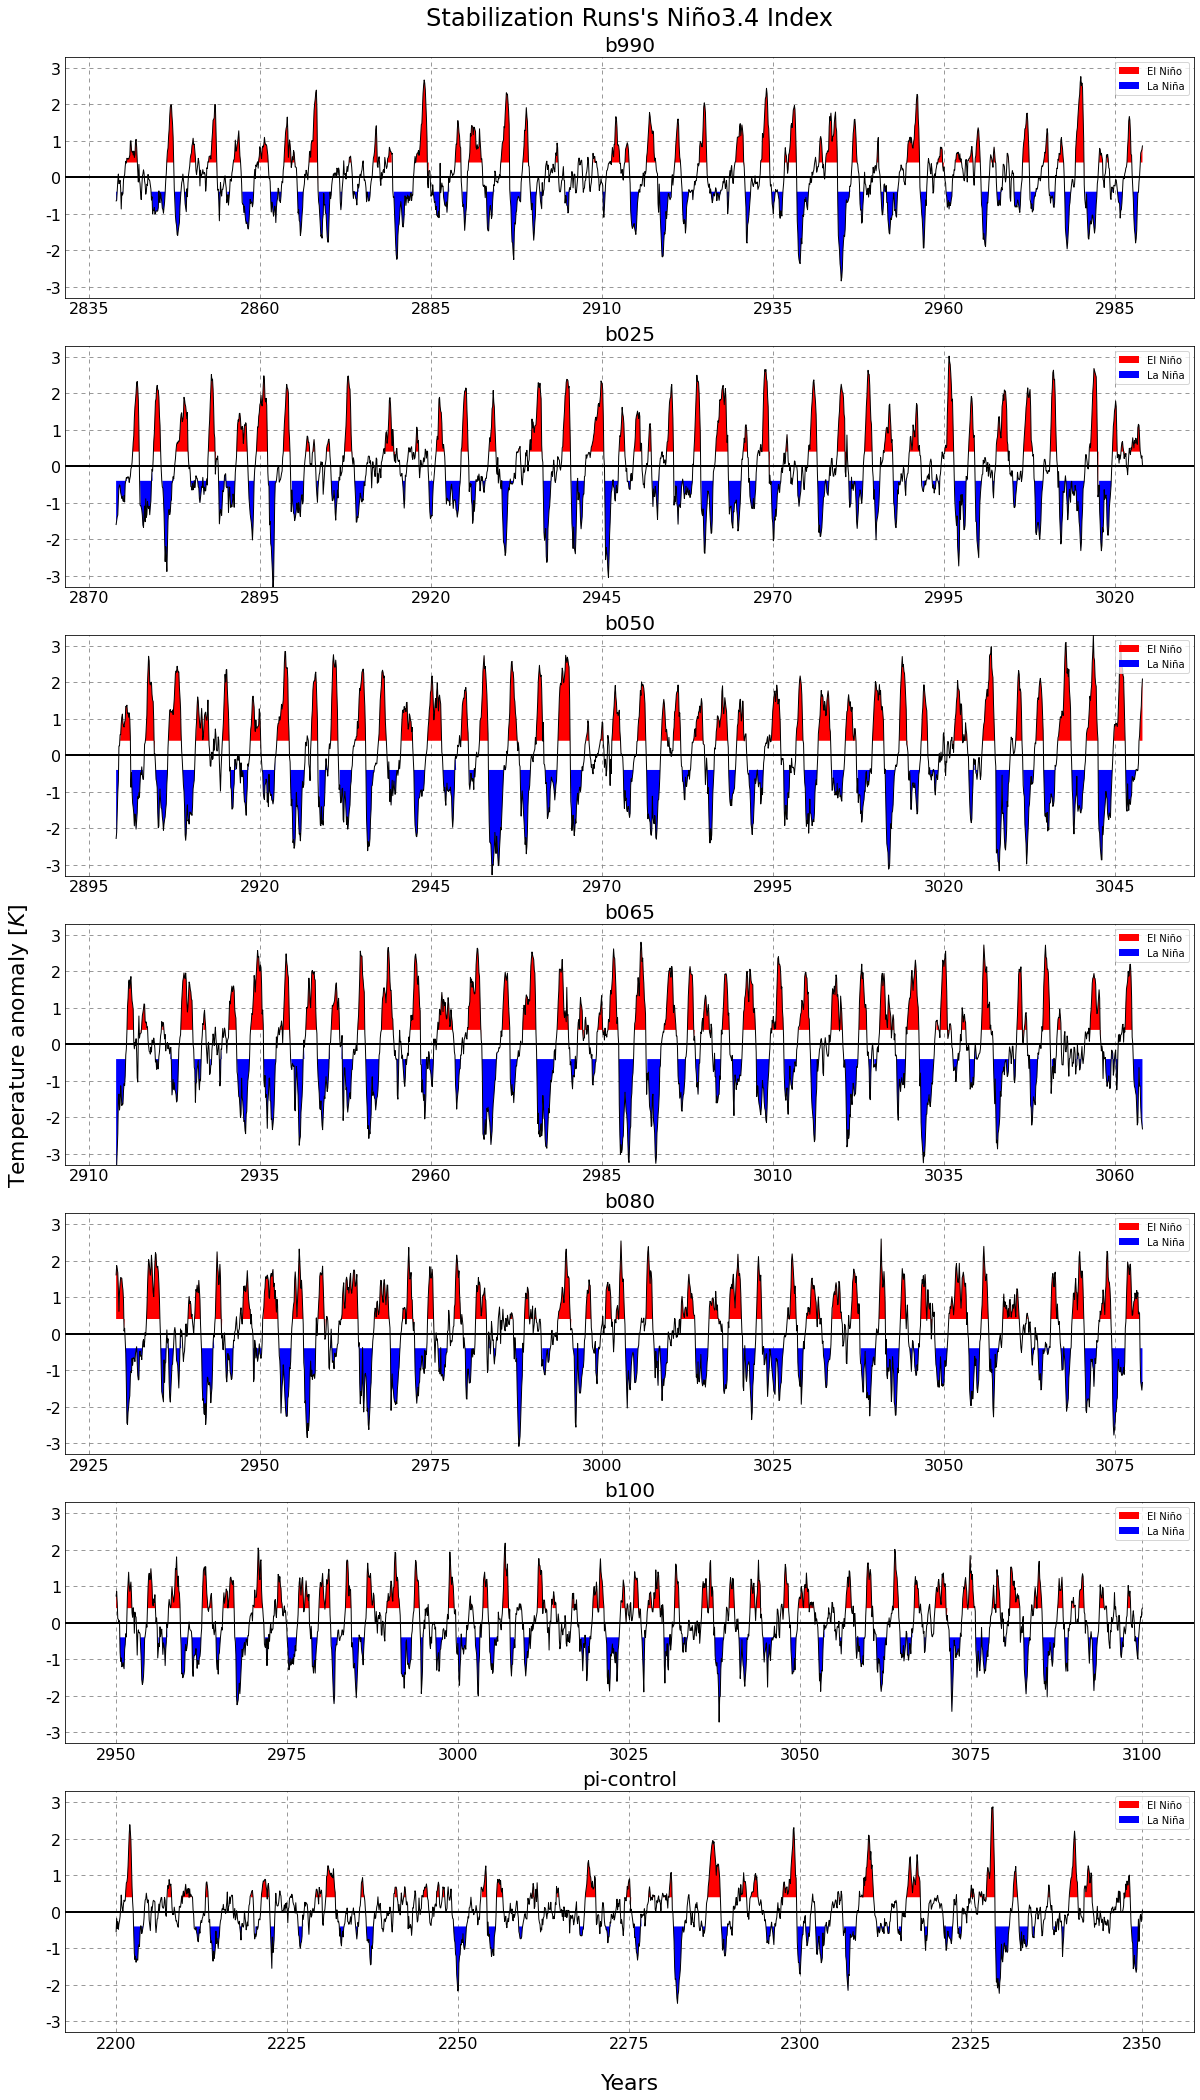

In [ ]:
###################################################################################
#################### Ninõ Index, last 150 years time series #######################
############## (Running Mean Detrending, time mean over Months) ###################
################## (1) ######## (SubPlot Line Plot) ###############################
###################################################################################
window = 150*12
# Creiamo una figura e gli assi dei subplots
fig, axs = plt.subplots(nrows=dataset_length-2, ncols=1, figsize=(16, 28))
plt.style.use('_mpl-gallery')
# Ora riempiamo ogni subplot con i dati dall'array
for i, dataset in enumerate(dataset_names):

   # Bottini + Pi-Controol
   if dataset not in ['hist', 'obs']:
      axs[i].plot(precomputed_index[dataset]['time'],
                   precomputed_index[dataset],
                       color='k', linewidth=1.0)
      axs[i].set_title('{}'.format(dataset), fontsize=20) # Niño3.4 Index - Running Mean detrended - Montly Averaged
      # Fill between the values of Index >= 0.4 and Index <= -0.4 with red and blue colors, respectively
      axs[i].fill_between(precomputed_index[dataset]['time'], 0.4, precomputed_index[dataset],
                           where = precomputed_index[dataset].rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4,
                            facecolor='red', interpolate=True, label='El Niño')
      axs[i].fill_between(precomputed_index[dataset]['time'], -0.4, precomputed_index[dataset],
                           where = precomputed_index[dataset].rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4,
                            facecolor='blue', interpolate=True, label='La Niña')
      # Set x-Axes ticks & labels
      axs[i].set_xticks(x_ticks_time[i])
      axs[i].set_xticklabels(x_labels_time[i], fontsize=16)
      axs[i].set_yticks(np.arange(-3,4,1))
      axs[i].set_yticklabels(np.arange(-3,4,1), fontsize=16)

"""    # Hist
   elif dataset in ['hist']:

      axs[i].plot(Index34_hist['time'], Index34_hist,  color='k', linewidth=1.0)
      axs[i].set_title('{}'.format(dataset), fontsize=20) # Niño3.4 Index - Running Mean detrended - Montly Averaged
      # Fill between the values of Index >= 0.4 and Index <= -0.4 with red and blue colors, respectively
      axs[i].fill_between(Index34_hist['time'], 0.4,  Index34_hist,
                        where = Index34_hist.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red', interpolate=True, label='El Niño')
      axs[i].fill_between(Index34_hist['time'], -0.4,  Index34_hist,
                        where = Index34_hist.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue', interpolate=True, label='La Niña')

   # Obs
   elif dataset in ['obs']:

      axs[i].plot(Index34_obs['time'], Index34_obs,  color='k', linewidth=1.0)
      axs[i].set_title('{}'.format(dataset), fontsize=20) # Niño3.4 Index - Running Mean detrended - Montly Averaged
      # Fill between the values of Index >= 0.4 and Index <= -0.4 with red and blue colors, respectively
      axs[i].fill_between(Index34_obs['time'], 0.4,  Index34_obs,
                        where = Index34_obs.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red', interpolate=True, label='El Niño')
      axs[i].fill_between(Index34_obs['time'], -0.4,  Index34_obs,
                        where = Index34_obs.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue', interpolate=True, label='La Niña') """

for ax in axs:
   # Add a legend on the Axes
   ax.legend(loc = 'upper right')
   # Set title and x-y axis labels for the Axes
   #axs[i].set_xlabel('Years', fontsize=12)
   #ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
   # Set y-Axes range
   ax.set_ylim(-3.3, 3.3)
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
   # Add a horizontal line in the Axes
   ax.axhline(y=0.0, color='black', linewidth=2)

# for i in range(n):
#    # Add a legend on the Axes
#    axs[i].legend(loc = 'upper right')
#    # Set title and x-y axis labels for the Axes
#    #axs[i].set_xlabel('Years', fontsize=12)
#    axs[i].set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
#    # Set y-Axes range
#    axs[i].set_ylim(-3.3, 3.3)

# Set a global title for the plot
fig.suptitle('Stabilization Runs\'s Niño3.4 Index',y=1.015, fontsize=24) #, y=1
fig.supxlabel('Years', y=-0.02, fontsize=22)
fig.supylabel('Temperature anomaly ' r'$[K]$', x=-0.04, y=0.5, fontsize=22)

#plt.subplots_adjust(hspace=0.25) #wspace=5
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'NinoIndex34-last150y.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'NinoIndex34-last150y.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

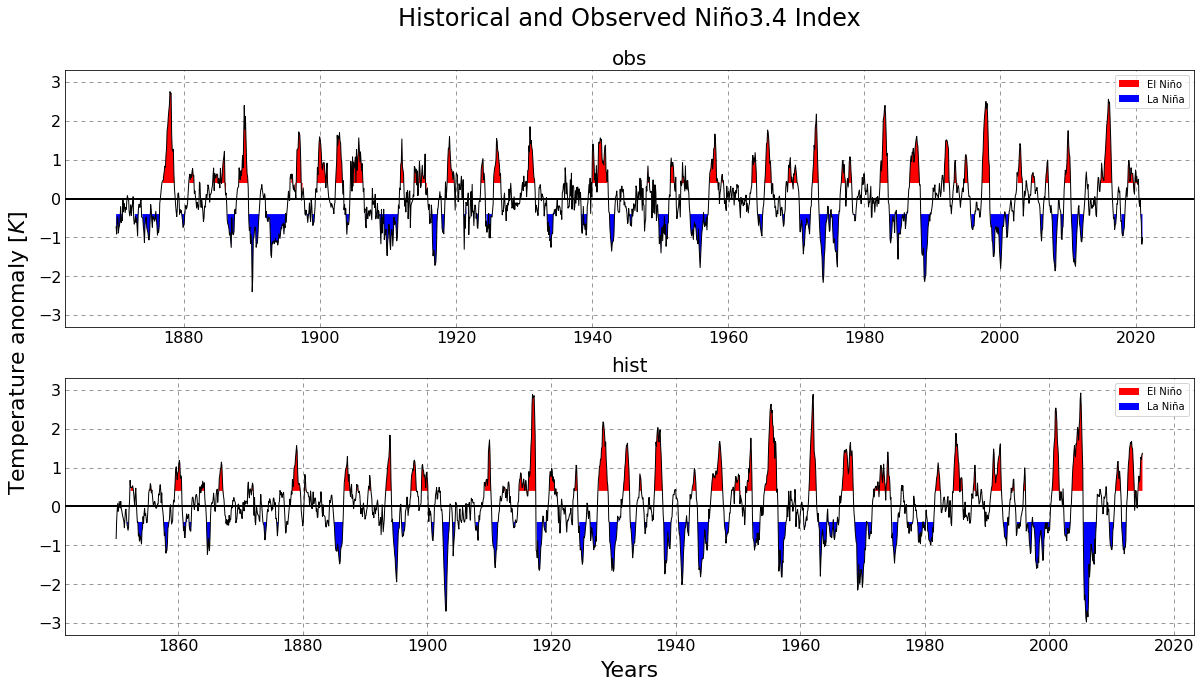

In [14]:
###################################################################################
#################### Ninõ Index, last 150 years time series #######################
############## (Running Mean Detrending, time mean over Months) ###################
################## (1-H+O) #### (SubPlot Line Plot) ###############################
###################################################################################
window = 150*12
# Creiamo una figura e gli assi dei subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plt.style.use('_mpl-gallery')
# Ora riempiamo ogni subplot con i dati dall'array
for dataset in dataset_names:
   # Obs
   if dataset in ['obs']:
      axs[0].plot(Index34_obs['time'], Index34_obs,  color='k', linewidth=1.0)
      axs[0].set_title('{}'.format(dataset), fontsize=20) # Niño3.4 Index - Running Mean detrended - Montly Averaged
      # Fill between the values of Index >= 0.4 and Index <= -0.4 with red and blue colors, respectively
      axs[0].fill_between(Index34_obs['time'], 0.4,  Index34_obs,
                        where = Index34_obs.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red', interpolate=True, label='El Niño')
      axs[0].fill_between(Index34_obs['time'], -0.4,  Index34_obs,
                        where = Index34_obs.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue', interpolate=True, label='La Niña')
   # Hist
   elif dataset in ['hist']:
      axs[1].plot(Index34_hist['time'], Index34_hist,  color='k', linewidth=1.0)
      axs[1].set_title('{}'.format(dataset), fontsize=20) # Niño3.4 Index - Running Mean detrended - Montly Averaged
      # Fill between the values of Index >= 0.4 and Index <= -0.4 with red and blue colors, respectively
      axs[1].fill_between(Index34_hist['time'], 0.4,  Index34_hist,
                        where = Index34_hist.rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red', interpolate=True, label='El Niño')
      axs[1].fill_between(Index34_hist['time'], -0.4,  Index34_hist,
                        where = Index34_hist.rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue', interpolate=True, label='La Niña')

for ax in axs:
   # Add a legend on the Axes
   ax.legend(loc = 'upper right')
   # Set title and x-y axis labels for the Axes
   #axs[i].set_xlabel('Years', fontsize=12)
   #ax.set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
   # Set y-Axes range
   ax.set_ylim(-3.3, 3.3)
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
   # Add a horizontal line in the Axes
   ax.axhline(y=0.0, color='black', linewidth=2)
   # Change the fontsize
   ax.tick_params(axis='x', labelsize=16)
   ax.tick_params(axis='y', labelsize=16)
# changing the fontsize of yticks
#plt.yticks(fontsize=16)

# Set a global title for the plot
fig.suptitle('Historical and Observed Niño3.4 Index',y=1.1, fontsize=24) #, y=1
fig.supxlabel('Years', y=-0.07, fontsize=22)
fig.supylabel('Temperature anomaly ' r'$[K]$', x=-0.04, y=0.5, fontsize=22)

#plt.subplots_adjust(hspace=0.25) #wspace=5
#plt.tight_layout()
# Display the figure
plt.show()
# # Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'NinoIndex34-last150y-HistObs.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'NinoIndex34-last150y-HistObs.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

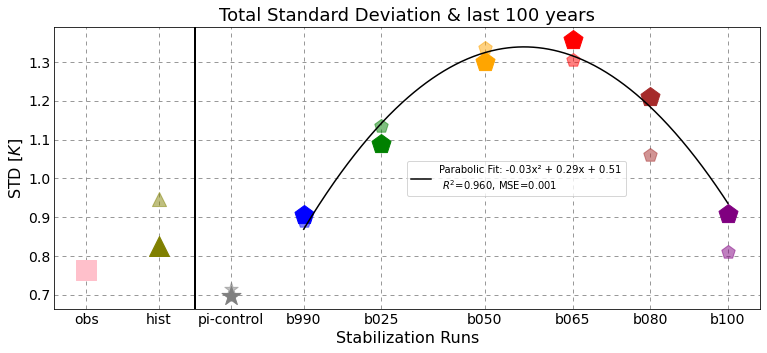

In [11]:
###################################################################################
#################### Full time series STD + last 100 years STD ####################
######### (3) ################### (Scatter Plot) ##################################
###################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(10, 4))
# Scatters plot
ax.scatter(x_ticks_std[0], std_T_obs, s=areaT, color=colors[8], marker=markers[3], alpha=1)
ax.scatter(x_ticks_std[0], std_window_obs, s=areaY, color=colors[8], marker=markers[3], alpha=0.5)
ax.scatter(x_ticks_std[1], std_T_hist, s=areaT, color=colors[7], marker=markers[2], alpha=1)
ax.scatter(x_ticks_std[1], std_window_hist, s=areaY, color=colors[7], marker=markers[2], alpha=0.5)
ax.scatter(x_ticks_std[2], std_T_pi, s=areaT, color=colors[6], marker=markers[1], alpha=1)
ax.scatter(x_ticks_std[2], std_window_pi, s=areaY, color=colors[6], marker=markers[1], alpha=0.5)
for i in range(len(dataset_names)-3):
   ax.scatter(x_ticks_std[i+3], std_T[i], s=areaT, color=colors[i], marker=markers[0], alpha=1)
   ax.scatter(x_ticks_std[i+3], std_window[i], s=areaY, color=colors[i], marker=markers[0], alpha=0.5)
# Plot della parabola
ax.plot(x_fit, y_fit, color='k', label=f'Parabolic Fit: {coefficients[0]:.2f}x² + {coefficients[1]:.2f}x + {coefficients[2]:.2f}\n $R^2$={r_squared_parab:.3f}, MSE={mse:.3f}')
#ax.legend(loc="best")
ax.legend(loc=(0.5,0.4))
# Set Labels
ax.set_xticks(x_ticks_std)
ax.set_xticklabels(['obs', 'hist', 'pi-control', 'b990', 'b025', 'b050', 'b065', 'b080', 'b100'], fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.axvline(-0.7, color='k', linewidth=2, linestyle='-')
ax.grid(linestyle='--', color='gray')
ax.set_title('Total Standard Deviation & last 100 years', fontsize=18)
ax.set_xlabel('Stabilization Runs', fontsize=16)
ax.set_ylabel('STD ' r'$[K]$', fontsize=16)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v0.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v0.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

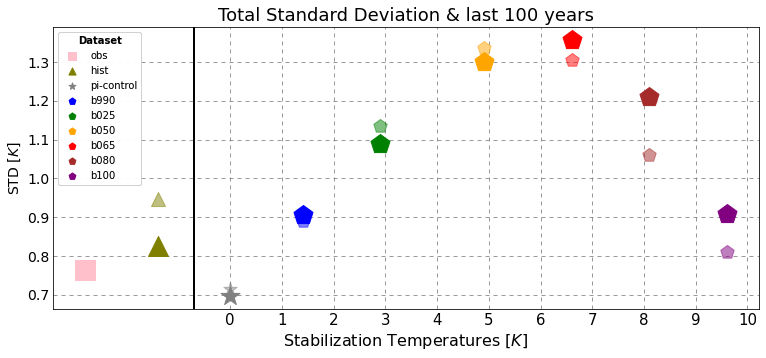

In [12]:
###################################################################################
#################### Full time series STD + last 100 years STD ####################
####################### (3.1) #### (Scatter Plot) #################################
###################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(10, 4))
scatter_handles = []  # Per salvare i riferimenti degli scatter
# Scatters plot
scatter_obs = ax.scatter(x_ticks_std[0], std_T_obs, s=areaT, color=colors[8], marker=markers[3], label=dataset_names[8], alpha=1)
scatter_handles.append(scatter_obs)
ax.scatter(x_ticks_std[0], std_window_obs, s=areaY, color=colors[8], marker=markers[3], alpha=0.5)
scatter_hist = ax.scatter(x_ticks_std[1], std_T_hist, s=areaT, color=colors[7], marker=markers[2], label=dataset_names[7], alpha=1)
scatter_handles.append(scatter_hist)
ax.scatter(x_ticks_std[1], std_window_hist, s=areaY, color=colors[7], marker=markers[2], alpha=0.5)
scatter_pi = ax.scatter(x_ticks_std[2], std_T_pi, s=areaT, color=colors[6], marker=markers[1], label=dataset_names[6], alpha=1)
scatter_handles.append(scatter_pi)
ax.scatter(x_ticks_std[2], std_window_pi, s=areaY, color=colors[6], marker=markers[1], alpha=0.5)
for i in range(len(dataset_names)-3):
   scatter = ax.scatter(x_ticks_std[i+3], std_T[i], s=areaT, color=colors[i], marker=markers[0], label=dataset_names[i], alpha=1)
   scatter_handles.append(scatter)
   ax.scatter(x_ticks_std[i+3], std_window[i], s=areaY, color=colors[i], marker=markers[0], alpha=0.5)
# Lengend
legend = ax.legend(handles=scatter_handles, title='Dataset', loc='upper left')
legend.get_title().set_fontweight('bold') 
# Riduci la dimensione dei marker nella legenda
for handle in legend.legendHandles:
    handle._sizes = [50]  # Imposta la dimensione dei marker nella legenda
ax.add_artist(legend)
# Set Labels
ax.set_xticks(np.arange(0, 11, 1))
ax.tick_params(axis='y', labelsize=14)
ax.axvline(-0.7, color='k', linewidth=2, linestyle='-')
ax.grid(linestyle='--', color='gray')
ax.set_title('Total Standard Deviation & last 100 years', fontsize=18)
ax.set_xlabel('Stabilization Temperatures ' r'$[K]$', fontsize=16)
ax.set_ylabel('STD ' r'$[K]$', fontsize=14)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v1.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v1.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

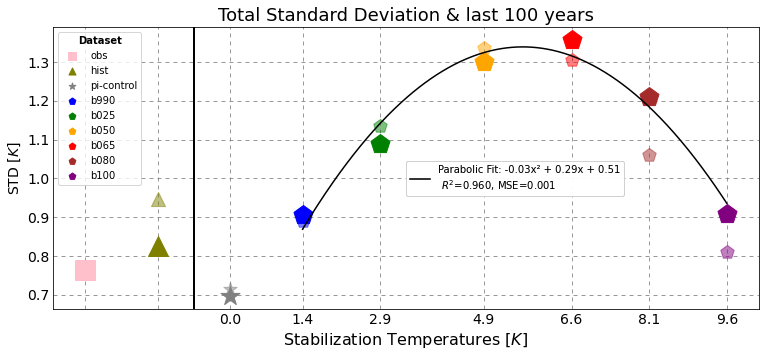

In [15]:
###################################################################################
#################### Full time series STD + last 100 years STD ####################
####################### (3.2) #### (Scatter Plot) #################################
###################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(10, 4))
scatter_handles = []  # Per salvare i riferimenti degli scatter
# Scatters plot
scatter_obs = ax.scatter(x_ticks_std[0], std_T_obs, s=areaT, color=colors[8], marker=markers[3], label=dataset_names[8], alpha=1)
scatter_handles.append(scatter_obs)
ax.scatter(x_ticks_std[0], std_window_obs, s=areaY, color=colors[8], marker=markers[3], alpha=0.5)
scatter_hist = ax.scatter(x_ticks_std[1], std_T_hist, s=areaT, color=colors[7], marker=markers[2], label=dataset_names[7], alpha=1)
scatter_handles.append(scatter_hist)
ax.scatter(x_ticks_std[1], std_window_hist, s=areaY, color=colors[7], marker=markers[2], alpha=0.5)
scatter_pi = ax.scatter(x_ticks_std[2], std_T_pi, s=areaT, color=colors[6], marker=markers[1], label=dataset_names[6], alpha=1)
scatter_handles.append(scatter_pi)
ax.scatter(x_ticks_std[2], std_window_pi, s=areaY, color=colors[6], marker=markers[1], alpha=0.5)
for i in range(len(dataset_names)-3):
   scatter = ax.scatter(x_ticks_std[i+3], std_T[i], s=areaT, color=colors[i], marker=markers[0], label=dataset_names[i], alpha=1)
   scatter_handles.append(scatter)
   ax.scatter(x_ticks_std[i+3], std_window[i], s=areaY, color=colors[i], marker=markers[0], alpha=0.5)
# Lengend
legend1 = ax.legend(handles=scatter_handles, title='Dataset', loc='upper left')
legend1.get_title().set_fontweight('bold') 
# Riduci la dimensione dei marker nella legenda
for handle in legend1.legendHandles:
    handle._sizes = [50]  # Imposta la dimensione dei marker nella legenda
ax.add_artist(legend1)
# Plot della parabola
fit_line = ax.plot(x_fit, y_fit, color='k', label=f'Parabolic Fit: {coefficients[0]:.2f}x² + {coefficients[1]:.2f}x + {coefficients[2]:.2f}\n $R^2$={r_squared_parab:.3f}, MSE={mse:.3f}')
#ax.legend(loc="best")
legend2 = ax.legend(handles=fit_line, loc=(0.5,0.4))
ax.add_artist(legend2)
# Set Labels
ax.set_xticks(x_ticks_std)
ax.set_xticklabels(x_labels_std, fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.axvline(-0.7, color='k', linewidth=2, linestyle='-')
ax.grid(linestyle='--', color='gray')
ax.set_title('Total Standard Deviation & last 100 years', fontsize=18)
ax.set_xlabel('Stabilization Temperatures ' r'$[K]$', fontsize=16)
ax.set_ylabel('STD ' r'$[K]$', fontsize=14)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v2.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v2.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

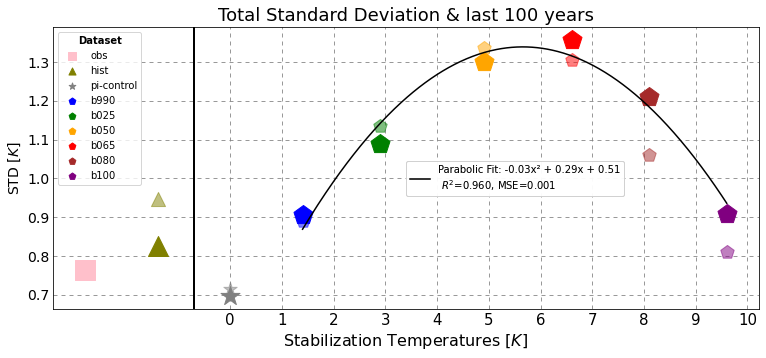

In [16]:
###################################################################################
#################### Full time series STD + last 100 years STD ####################
####################### (3.3) #### (Scatter Plot) #################################
###################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(10, 4))
scatter_handles = []  # Per salvare i riferimenti degli scatter
# Scatters plot
scatter_obs = ax.scatter(x_ticks_std[0], std_T_obs, s=areaT, color=colors[8], marker=markers[3], label=dataset_names[8], alpha=1)
scatter_handles.append(scatter_obs)
ax.scatter(x_ticks_std[0], std_window_obs, s=areaY, color=colors[8], marker=markers[3], alpha=0.5)
scatter_hist = ax.scatter(x_ticks_std[1], std_T_hist, s=areaT, color=colors[7], marker=markers[2], label=dataset_names[7], alpha=1)
scatter_handles.append(scatter_hist)
ax.scatter(x_ticks_std[1], std_window_hist, s=areaY, color=colors[7], marker=markers[2], alpha=0.5)
scatter_pi = ax.scatter(x_ticks_std[2], std_T_pi, s=areaT, color=colors[6], marker=markers[1], label=dataset_names[6], alpha=1)
scatter_handles.append(scatter_pi)
ax.scatter(x_ticks_std[2], std_window_pi, s=areaY, color=colors[6], marker=markers[1], alpha=0.5)
for i in range(len(dataset_names)-3):
   scatter = ax.scatter(x_ticks_std[i+3], std_T[i], s=areaT, color=colors[i], marker=markers[0], label=dataset_names[i], alpha=1)
   scatter_handles.append(scatter)
   ax.scatter(x_ticks_std[i+3], std_window[i], s=areaY, color=colors[i], marker=markers[0], alpha=0.5)
# Lengend
legend1 = ax.legend(handles=scatter_handles, title='Dataset', loc='upper left')
legend1.get_title().set_fontweight('bold') 
# Riduci la dimensione dei marker nella legenda
for handle in legend1.legendHandles:
    handle._sizes = [50]  # Imposta la dimensione dei marker nella legenda
ax.add_artist(legend1)
# Plot della parabola
fit_line = ax.plot(x_fit, y_fit, color='k', label=f'Parabolic Fit: {coefficients[0]:.2f}x² + {coefficients[1]:.2f}x + {coefficients[2]:.2f}\n $R^2$={r_squared_parab:.3f}, MSE={mse:.3f}')
#ax.legend(loc="best")
legend2 = ax.legend(handles=fit_line, loc=(0.5,0.4))
ax.add_artist(legend2)
# Set Labels
ax.set_xticks(np.arange(0, 11, 1))
ax.tick_params(axis='y', labelsize=14)
ax.axvline(-0.7, color='k', linewidth=2, linestyle='-')
ax.grid(linestyle='--', color='gray')
ax.set_title('Total Standard Deviation & last 100 years', fontsize=18)
ax.set_xlabel('Stabilization Temperatures ' r'$[K]$', fontsize=16)
ax.set_ylabel('STD ' r'$[K]$', fontsize=14)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v3.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v3.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

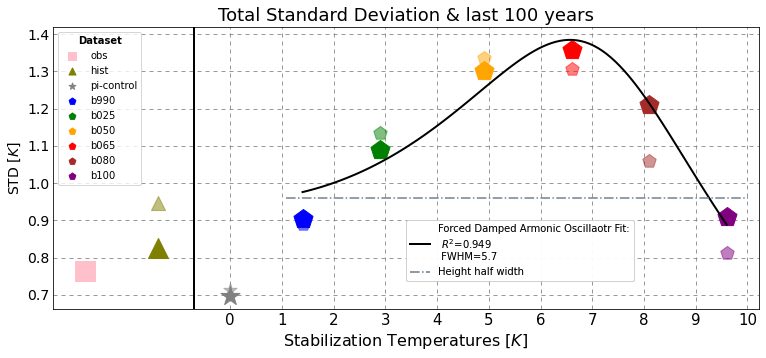

In [17]:
###################################################################################
#################### Full time series STD + last 100 years STD ####################
####################### (3.4) #### (Scatter Plot) #################################
###################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(10, 4))
scatter_handles = []  # Per salvare i riferimenti degli scatter
# Scatters plot
scatter_obs = ax.scatter(x_ticks_std[0], std_T_obs, s=areaT, color=colors[8], marker=markers[3], label=dataset_names[8], alpha=1)
scatter_handles.append(scatter_obs)
ax.scatter(x_ticks_std[0], std_window_obs, s=areaY, color=colors[8], marker=markers[3], alpha=0.5)
scatter_hist = ax.scatter(x_ticks_std[1], std_T_hist, s=areaT, color=colors[7], marker=markers[2], label=dataset_names[7], alpha=1)
scatter_handles.append(scatter_hist)
ax.scatter(x_ticks_std[1], std_window_hist, s=areaY, color=colors[7], marker=markers[2], alpha=0.5)
scatter_pi = ax.scatter(x_ticks_std[2], std_T_pi, s=areaT, color=colors[6], marker=markers[1], label=dataset_names[6], alpha=1)
scatter_handles.append(scatter_pi)
ax.scatter(x_ticks_std[2], std_window_pi, s=areaY, color=colors[6], marker=markers[1], alpha=0.5)
for i in range(len(dataset_names)-3):
   scatter = ax.scatter(x_ticks_std[i+3], std_T[i], s=areaT, color=colors[i], marker=markers[0], label=dataset_names[i], alpha=1)
   scatter_handles.append(scatter)
   ax.scatter(x_ticks_std[i+3], std_window[i], s=areaY, color=colors[i], marker=markers[0], alpha=0.5)
# Lengend
legend1 = ax.legend(handles=scatter_handles, title='Dataset', loc='upper left')
legend1.get_title().set_fontweight('bold') 
# Riduci la dimensione dei marker nella legenda
for handle in legend1.legendHandles:
    handle._sizes = [50]  # Imposta la dimensione dei marker nella legenda
ax.add_artist(legend1)
# Plot del fit
fit_line = ax.plot(x_std_interp, forced_damped_oscillator(x_std_interp, *params), label=f'Forced Damped Armonic Oscillaotr Fit:\n $R^2$={r_squared_fdao:.3f}\n FWHM={fwhm:.1f}', color='k', linewidth=2)
# Set Labels
ax.set_xticks(np.arange(0, 11, 1))
ax.tick_params(axis='y', labelsize=14)
ax.axvline(-0.7, color='k', linewidth=2, linestyle='-')
height_half_width_line = ax.axhline(y=np.max(y_std/np.sqrt(2)), xmin=0.33, xmax=0.985, color='slategray', linestyle='-.', label='Height half width')
# Legenda
#ax.legend(loc="best")
fit_handles = fit_line + [height_half_width_line]
legend2 = ax.legend(handles=fit_handles, loc=(0.5,0.1))
ax.add_artist(legend2)
ax.grid(linestyle='--', color='gray')
ax.set_title('Total Standard Deviation & last 100 years', fontsize=18)
ax.set_xlabel('Stabilization Temperatures ' r'$[K]$', fontsize=16)
ax.set_ylabel('STD ' r'$[K]$', fontsize=14)
# Display the figure
plt.show()
# # Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v4.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdTstdW_v4.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

In [ ]:
"""
Differenze dalla vecchia versione:
   - i valori assoluti delle std_T cambiano poco, il dataset che riscontra il maggior cambiamento è lo storico;
   - la cosa che riscontra più interesse è la variazione delle std_window degli ultimi 100 anni: in generale si può affermare che il discostamento degli ultimi 100 anni è ora generalmente maggiore nei seguenti datset: hist (in primis); b025; b050 (precedentemente quasi nullo); b100

"""

In [18]:
with open(common_dir_proj+Dir_output_plot+'Task-5_std_RM.pkl', 'rb') as file:
   # Load the variables
   precomputed_std_RM = pickle.load(file)
file.close()

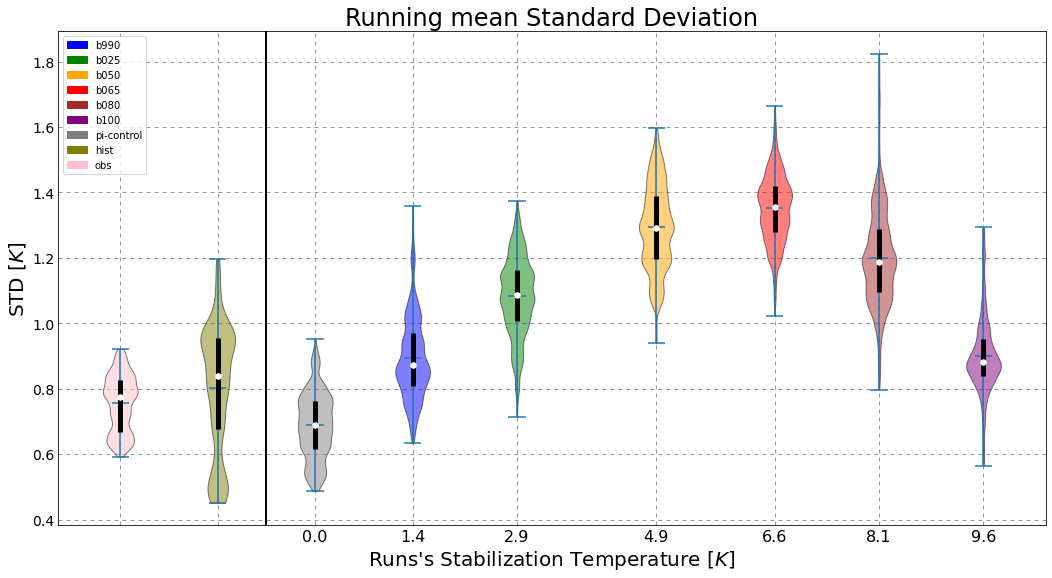

In [32]:
###################################################################################
########################### Time series RM STD ####################################
############### (4) ######## (Violin-Box Plot) ####################################
###################################################################################
# Creazione della lista dei dati per i stdx_ticks_stdi
violin_data = [precomputed_std_RM['obs'], precomputed_std_RM['hist'], precomputed_std_RM['pi-control']] + [precomputed_std_RM[dataset] for dataset in dataset_names[:6]] # solo ultimi 500 anni dei bottini
color_std_violin = [colors[8], colors[7], colors[6]] + [colors[i] for i in range(len(dataset_names)-3)]
# Creazione del plot
fig, ax = plt.subplots(figsize=(14, 7))
plt.style.use('_mpl-gallery')
# Disegno del stdx_ticks_std plot
violin = ax.violinplot(violin_data, vert=True, showmeans=True, showmedians=False, positions=x_ticks_std)

# 'fake' invisible object creation for legend
patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]

# Update the legend with the handles dictionary
ax.legend(patches, dataset_names, loc = 'upper left')

# fill with colors
for i, violin in enumerate(violin['bodies']):
    violin.set_facecolor(color_std_violin[i])
    violin.set_edgecolor('black')
    violin.set_alpha(0.5)


 # Statistics
quartile1_obs, medians_obs, quartile3_obs = np.percentile(precomputed_std_RM['obs'], [25, 50, 75], axis=0)
quartile1_hist, medians_hist, quartile3_hist = np.percentile(precomputed_std_RM['hist'], [25, 50, 75], axis=0)
quartile1_pi, medians_pi, quartile3_pi = np.percentile(precomputed_std_RM['pi-control'], [25, 50, 75], axis=0)

quartile1, medians, quartile3 = [None]*len(dataset_names[:6]), [None]*len(dataset_names[:6]), [None]*len(dataset_names[:6])
for i in range(len(dataset_names[:6])):
    quartile1[i], medians[i], quartile3[i] = np.percentile(precomputed_std_RM[dataset_names[i]], [25, 50, 75], axis=0)

#quartile1 = [quartile1_obs, quartile1_hist, quartile1_pi, quartile1]
quartile1.insert(0, quartile1_obs)
quartile1.insert(1, quartile1_hist)
quartile1.insert(2, quartile1_pi)

medians.insert(0, medians_obs)
medians.insert(1, medians_hist)
medians.insert(2, medians_pi)

#quartile3 = [quartile3_obs, quartile3_hist, quartile3_pi, quartile3]
quartile3.insert(0, quartile3_obs)
quartile3.insert(1, quartile3_hist)
quartile3.insert(2, quartile3_pi)

ax.scatter(x_ticks_std, medians, marker='o', color='white', s=30, zorder=3,)
ax.vlines(x_ticks_std, quartile1, quartile3, color='k', linestyle='-', lw=5)
#ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# Set Labels
ax.set_xticks(x_ticks_std)
ax.set_xticklabels(x_labels_std, fontsize=16)
ax.tick_params(axis='y', labelsize=14)
#ax.set_xticks(np.arange(1, len(dataset_names) + 1), labels=stab_temp) #[y + 1 for y in range(n)]
# Add vertical line
ax.axvline(-0.7, color='k', linewidth=2, linestyle='-')
# adding horizontal grid lines
ax.grid(linestyle='--', color='gray')
ax.set_title('Running mean Standard Deviation', fontsize=24)
ax.set_xlabel('Runs\'s Stabilization Temperature ' r'$[K]$', fontsize=20)
ax.set_ylabel('STD ' r'$[K]$', fontsize=20)
#plt.tight_layout()
# Show the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdRM_v1.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdRM_v1.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

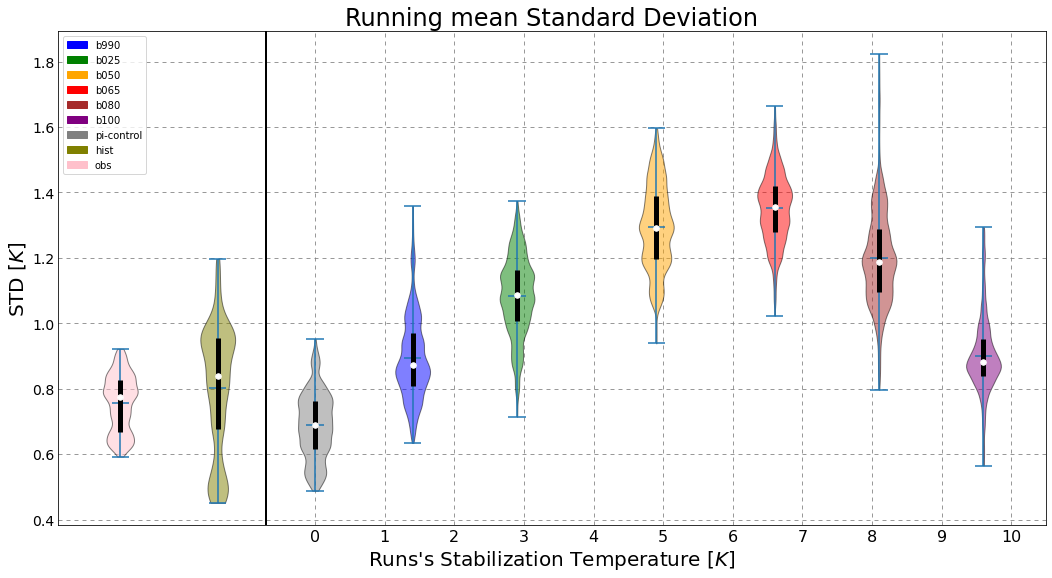

In [ ]:
###################################################################################
########################### Time series RM STD ####################################
############### (4.1) ##### (Violin-Box Plot) ####################################
###################################################################################
# Creazione della lista dei dati per i stdx_ticks_stdi
violin_data = [precomputed_std_RM['obs'], precomputed_std_RM['hist'], precomputed_std_RM['pi-control']] + [precomputed_std_RM[dataset] for dataset in dataset_names[:6]] # solo ultimi 500 anni dei bottini
color_std_violin = [colors[8], colors[7], colors[6]] + [colors[i] for i in range(len(dataset_names)-3)]
# Creazione del plot
fig, ax = plt.subplots(figsize=(14, 7))
plt.style.use('_mpl-gallery')
# Disegno del stdx_ticks_std plot
violin = ax.violinplot(violin_data, vert=True, showmeans=True, showmedians=False, positions=x_ticks_std)

# 'fake' invisible object creation for legend
patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]

# Update the legend with the handles dictionary
ax.legend(patches, dataset_names, loc = 'upper left')

# fill with colors
for i, violin in enumerate(violin['bodies']):
    violin.set_facecolor(color_std_violin[i])
    violin.set_edgecolor('black')
    violin.set_alpha(0.5)


 # Statistics
quartile1_obs, medians_obs, quartile3_obs = np.percentile(precomputed_std_RM['obs'], [25, 50, 75], axis=0)
quartile1_hist, medians_hist, quartile3_hist = np.percentile(precomputed_std_RM['hist'], [25, 50, 75], axis=0)
quartile1_pi, medians_pi, quartile3_pi = np.percentile(precomputed_std_RM['pi-control'], [25, 50, 75], axis=0)

quartile1, medians, quartile3 = [None]*len(dataset_names[:6]), [None]*len(dataset_names[:6]), [None]*len(dataset_names[:6])
for i in range(len(dataset_names[:6])):
    quartile1[i], medians[i], quartile3[i] = np.percentile(precomputed_std_RM[dataset_names[i]], [25, 50, 75], axis=0)

#quartile1 = [quartile1_obs, quartile1_hist, quartile1_pi, quartile1]
quartile1.insert(0, quartile1_obs)
quartile1.insert(1, quartile1_hist)
quartile1.insert(2, quartile1_pi)

medians.insert(0, medians_obs)
medians.insert(1, medians_hist)
medians.insert(2, medians_pi)

#quartile3 = [quartile3_obs, quartile3_hist, quartile3_pi, quartile3]
quartile3.insert(0, quartile3_obs)
quartile3.insert(1, quartile3_hist)
quartile3.insert(2, quartile3_pi)

ax.scatter(x_ticks_std, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(x_ticks_std, quartile1, quartile3, color='k', linestyle='-', lw=5)
#ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# Set Labels
ax.set_xticks(np.arange(0, 11, 1))
ax.set_xticklabels([str(i) for i in range(11)], fontsize=16)
ax.tick_params(axis='y', labelsize=14)
#ax.set_xticks(np.arange(1, len(dataset_names) + 1), labels=stab_temp) #[y + 1 for y in range(n)]
# Add vertical line
ax.axvline(-0.7, color='k', linewidth=2, linestyle='-')
# adding horizontal grid lines
ax.grid(linestyle='--', color='gray')
ax.set_title('Running mean Standard Deviation', fontsize=24)
ax.set_xlabel('Runs\'s Stabilization Temperature ' r'$[K]$', fontsize=20)
ax.set_ylabel('STD ' r'$[K]$', fontsize=20)
#plt.tight_layout()
# Show the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdRM_v2.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdRM_v2.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

In [ ]:
"""
Differenze dalla vecchia versione:
   - in generale, ad eccezione del pi-control, c'è un incremento della variaibiluità della std: il range che ricoprono i valori ha un'ampiezza maggiore. il dataset dello storico è quello che maggiormente vede questo effetto; Questo è dovuto al cambio della finestra su cui fare la RM da 50 a 30 anni e senza andare a taglaire teste e code.
   (- al contrario del caso precedente la mediana è superiore alla media nei datasets: obs, hist; mentre è inferiore nel b080, b100;)
"""

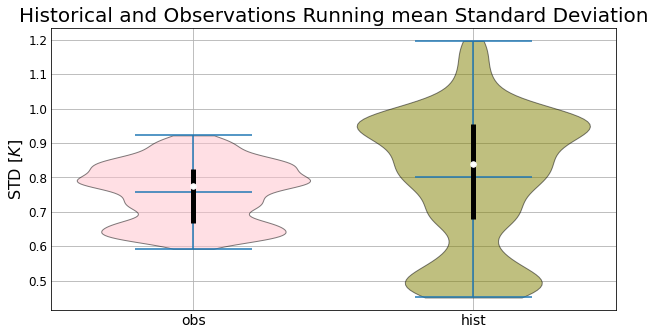

In [20]:
###################################################################################
########################### Time series RM STD ####################################
######### (4-H+O) ########## (Violin-Box Plot) ####################################
###################################################################################
# Creazione della lista dei dati per i stdx_ticks_stdi
violin_data = [precomputed_std_RM['obs'], precomputed_std_RM['hist']]
color_std_violin = [colors[8], colors[7]]
# Creazione del plot
fig, ax = plt.subplots(figsize=(8, 4))
plt.style.use('_mpl-gallery')
# Disegno del stdx_ticks_std plot
violin = ax.violinplot(violin_data, vert=True, showmeans=True, showmedians=False, positions=[0.2, 0.8])

# fill with colors
for i, violin in enumerate(violin['bodies']):
    violin.set_facecolor(color_std_violin[i])
    violin.set_edgecolor('black')
    violin.set_alpha(0.5)

# Statistics
quartile1, medians, quartile3 = [None]*len(dataset_names[7:]), [None]*len(dataset_names[7:]), [None]*len(dataset_names[7:])
quartile1_obs, medians_obs, quartile3_obs = np.percentile(precomputed_std_RM['obs'], [25, 50, 75], axis=0)
quartile1_hist, medians_hist, quartile3_hist = np.percentile(precomputed_std_RM['hist'], [25, 50, 75], axis=0)

quartile1[0] = quartile1_obs; quartile1[1] = quartile1_hist;

medians[0] = medians_obs; medians[1] = medians_hist;

quartile3[0] = quartile3_obs; quartile3[1] = quartile3_hist;

ax.scatter([0.2, 0.8], medians, marker='o', color='white', s=30, zorder=3)
ax.vlines([0.2, 0.8], quartile1, quartile3, color='k', linestyle='-', lw=5)

# Set Labels
ax.set_xticks([0.2, 0.8])
ax.set_xticklabels(dataset_names[7:][::-1], fontsize=14)
ax.tick_params(axis='y', labelsize=12)

# adding horizontal grid lines
#ax.grid(linestyle='--', color='gray')
ax.set_title('Historical and Observations Running mean Standard Deviation', fontsize=20)
ax.set_ylabel('STD ' r'$[K]$', fontsize=16)
#plt.tight_layout()
# Show the figure
plt.show()
# # Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdRM-HistObs.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'Datasets_stdRM-HistObs.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

(11042, 6) (5054,)


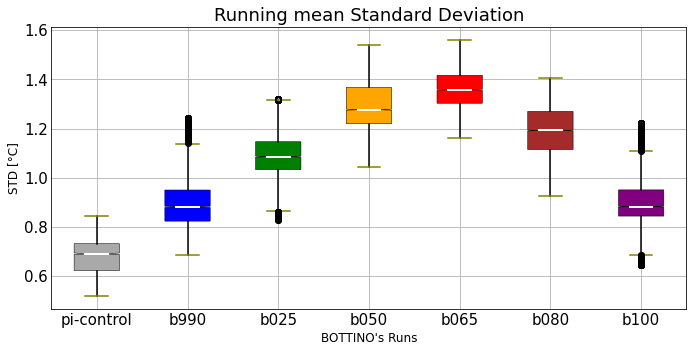

In [ ]:
std_RM, std_RM_pi= pickle.load(open(common_dir_proj + Dir_output_plot + 'Task-5_std_RM.p', 'rb'))
#std_RM = std_RM[0]
print(np.shape(std_RM), np.shape(std_RMM_pi))
###################################################################################
######## (4-bis) ########### Time series RM STD ###################################
############################### (Box Plot) ########################################
###################################################################################
fig, ax = plt.subplots(figsize=(9, 4))
plt.style.use('_mpl-gallery')
# notch shape box plot
bplot = ax.boxplot([std_RM_pi, std_RM[:,0], std_RM[:,1], std_RM[:,2], std_RM[:,3], std_RM[:,4], std_RM[:,5]],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=dataset_names,  # will be used to label x-ticks
                     bootstrap=1000,
                     medianprops={"color": "white", "linewidth": 2},
                     boxprops={"edgecolor": "k", "linewidth": 0.5}, # "facecolor": "k" --> impone il colore dell'interno de box ma uguale per tutti 
                     whiskerprops={"color": "k", "linewidth": 1.5},
                     capprops={"color": "olive", "linewidth": 1.5})
ax.set_title('Running mean Standard Deviation', fontsize=18)

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
   patch.set_facecolor(color)

# adding horizontal grid lines
ax.yaxis.grid(True)
ax.set_xlabel('Stabilization Runs', fontsize=12)
ax.set_ylabel('STD [°C]', fontsize=12)
# Show the figure
plt.show()
# Save the current figure to a file
fig.savefig('/home/montanarini/images/task5-NinoIndexes//BOTTINOS_std_RM-Box.pdf', bbox_inches='tight', dpi=300)

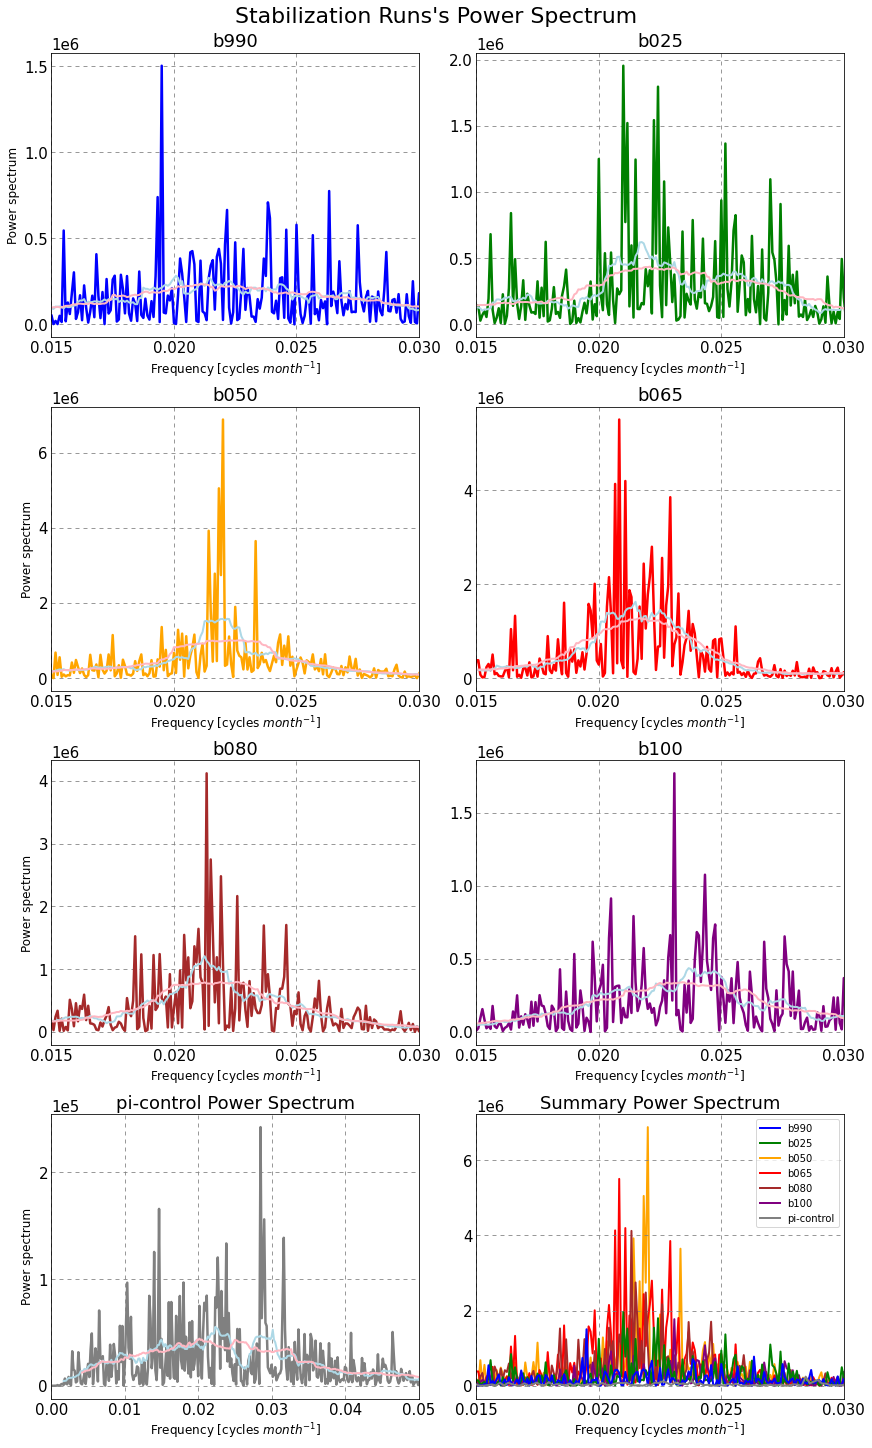

In [ ]:
##############################################################################
############################ Power Spectra ###################################
######## (5) ############ (SubPlot Line Plot) ################################
##############################################################################
# Ordine di sovrapposizione nel plot omnicomprensivo
zorder = [3.0,2.5,2.0,0,0.5,1.0,1.5]
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(zorder)
for i in range(len(zorder)):
   if i<(len(zorder)-1):
      idx[i]=freqs[i] > 0
   else:
      idx[i]=freqs_pi > 0
#idx = np.roll(idx, 1) #Faccio slittare tutto di 1 in avanti per causa del pi-control che non fa parte della stessa variaile degli altri bottini
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,20), layout='constrained')
for i, dataset in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   if dataset not in ['pi-control', 'hist', 'obs']:
      # Plot y versus x as lines in the Axes
      axs[row, col].plot(freqs[i][idx[i]], power_spec[i][idx[i]], color=colors[i], linewidth = 2.5)
      #ps_low = ctl.butter_filter(ps, 20)
      ps_low = ctl.running_mean(power_spec[i], 20)
      axs[row, col].plot(freqs[i][idx[i]], ps_low[idx[i]], color='lightblue', linewidth = 2)
      #ps_low = ctl.butter_filter(ps, 50)
      ps_low = ctl.running_mean(power_spec[i], 50)
      axs[row, col].plot(freqs[i][idx[i]], ps_low[idx[i]], color='lightpink', linewidth = 2)
      axs[row, col].set_title(f'{dataset}', fontsize=18)
      # Plot collettivo
      axs[3, 1].plot(freqs[i][idx[i]], power_spec[i][idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
   elif dataset in ['pi-control']:
      # Plot y versus x as lines in the Axes
      axs[row, col].plot(freqs_pi[idx[i]], power_spec_pi[idx[i]], color=colors[i], linewidth = 2.5)
      ps_low = ctl.running_mean(power_spec_pi, 20)
      axs[row, col].plot(freqs_pi[idx[i]], ps_low[idx[i]], color='lightblue', linewidth = 2)
      ps_low = ctl.running_mean(power_spec_pi, 50)
      axs[row, col].plot(freqs_pi[idx[i]], ps_low[idx[i]], color='lightpink', linewidth = 2)
      axs[row, col].set_title(f'{dataset} Power Spectrum', fontsize=18)
      axs[row, col].set_ylabel('Power spectrum', fontsize=12)
      # Plot collettivo
      axs[3, 1].plot(freqs_pi[idx[i]], power_spec_pi[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)
      # Add a legend on the Axes
      axs[3, 1].legend(loc = 'upper right')
      axs[3, 1].set_title('Summary Power Spectrum', fontsize=18)
   
   if col == 0 and row<4:
      axs[row, col].set_ylabel('Power spectrum', fontsize=12)

# Set title and x-y axis labels for the Axes
for ax in axs.flat:
   # Set x & y-axis limit
   ax.set_xlim(0.015, 0.03)
   # Set x-axis ticks
   ax.locator_params(nbins=5)
   # Set title and x-y axis labels for the Axes
   ax.set_xlabel('Frequency [cycles ' r'$month^{-1}]$', fontsize=12)
   #ax.set_ylabel('Power spectrum', fontsize=12)
   # Set the axis notation
   ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
axs[3,0].set_xlim(0.0, 0.05)
fig.suptitle('Stabilization Runs\'s Power Spectrum', fontsize=22)
#fig.supylabel('Power spectrum', fontsize=14)
#plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra_v1.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra_v1.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

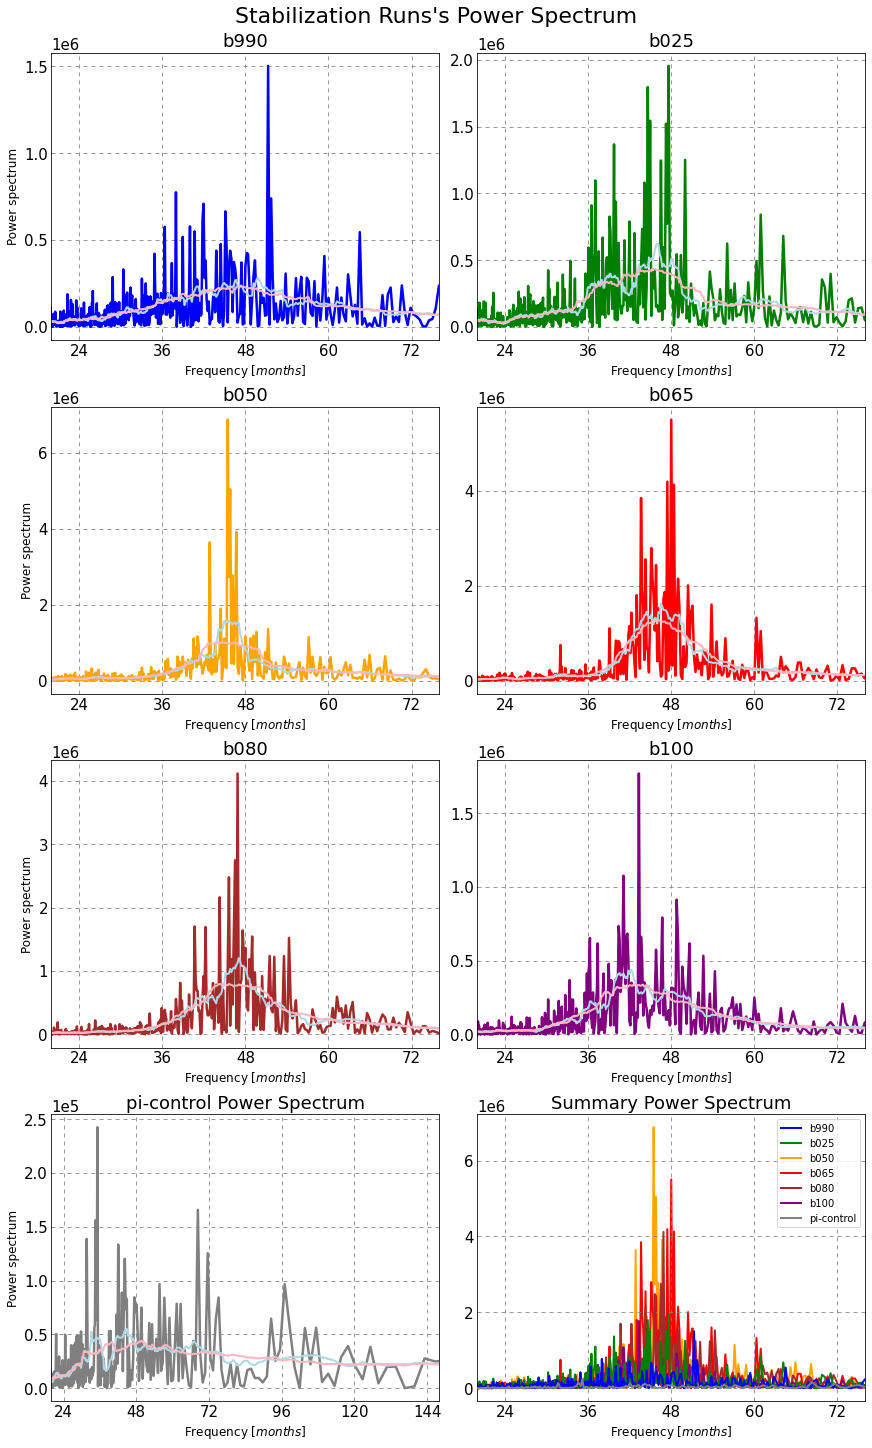

In [ ]:
##############################################################################
############################ Power Spectra ###################################
######## (5.1) ########## (SubPlot Line Plot) ################################
##############################################################################
# Ordine di sovrapposizione nel plot omnicomprensivo
zorder = [3.0,2.5,2.0,0,0.5,1.0,1.5]
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(zorder)
for i in range(len(zorder)):
   if i<(len(zorder)-1):
      idx[i]=freqs[i] > 0
   else:
      idx[i]=freqs_pi > 0
#idx = np.roll(idx, 1) #Faccio slittare tutto di 1 in avanti per causa del pi-control che non fa parte della stessa variaile degli altri bottini
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,20), layout='constrained')
for i, dataset in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   if dataset not in ['pi-control', 'hist', 'obs']:
      # Plot y versus x as lines in the Axes
      axs[row, col].plot(1/(freqs[i][idx[i]]), power_spec[i][idx[i]], color=colors[i], linewidth = 2.5)
      #ps_low = ctl.butter_filter(ps, 20)
      ps_low = ctl.running_mean(power_spec[i], 20)
      axs[row, col].plot(1/(freqs[i][idx[i]]), ps_low[idx[i]], color='lightblue', linewidth = 2)
      #ps_low = ctl.butter_filter(ps, 50)
      ps_low = ctl.running_mean(power_spec[i], 50)
      axs[row, col].plot(1/(freqs[i][idx[i]]), ps_low[idx[i]], color='lightpink', linewidth = 2)
      axs[row, col].set_title(f'{dataset}', fontsize=18)
      # Plot collettivo
      axs[3, 1].plot(1/(freqs[i][idx[i]]), power_spec[i][idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
   elif dataset in ['pi-control']:
      # Plot y versus x as lines in the Axes
      axs[row, col].plot(1/(freqs_pi[idx[i]]), power_spec_pi[idx[i]], color=colors[i], linewidth = 2.5)
      ps_low = ctl.running_mean(power_spec_pi, 20)
      axs[row, col].plot(1/(freqs_pi[idx[i]]), ps_low[idx[i]], color='lightblue', linewidth = 2)
      ps_low = ctl.running_mean(power_spec_pi, 50)
      axs[row, col].plot(1/(freqs_pi[idx[i]]), ps_low[idx[i]], color='lightpink', linewidth = 2)
      axs[row, col].set_title(f'{dataset} Power Spectrum', fontsize=18)
      axs[row, col].set_ylabel('Power spectrum', fontsize=12)
      # Plot collettivo
      axs[3, 1].plot(1/(freqs_pi[idx[i]]), power_spec_pi[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)
      # Add a legend on the Axes
      axs[3, 1].legend(loc = 'upper right')
      axs[3, 1].set_title('Summary Power Spectrum', fontsize=18)
   
   if col == 0 and row<4:
      axs[row, col].set_ylabel('Power spectrum', fontsize=12)

# Set title and x-y axis labels for the Axes
for ax in axs.flat:
   # Set x & y-axis limit, thicks and labels
   ax.set_xlim(20, 76)
   ax.set_xticks(x_ticks_ps)
   ax.set_xticklabels(x_labels_ps)
   # Set x-axis ticks
   ax.locator_params(nbins=5)
   # Set title and x-y axis labels for the Axes
   ax.set_xlabel('Frequency ' r'$[months]$', fontsize=12)
   #ax.set_ylabel('Power spectrum', fontsize=12)
   # Set the axis notation
   ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
# Pi-control subplot settings
axs[3, 0].set_xlim(20, 148)
axs[3, 0].set_xticks(x_ticks_ps_ext[:6])
axs[3, 0].set_xticklabels(x_labels_ps_ext[:6])
axs[3, 0].locator_params(nbins=6)
fig.suptitle('Stabilization Runs\'s Power Spectrum', fontsize=22)
#fig.supylabel('Power spectrum', fontsize=14)
#plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra_v2.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra_v2.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

In [ ]:
"""
Differenze dalla vecchia versione:
   - analisi delle frequenze:
      - i seguenti dataset hanno dei picchi più intensi del caso precedente: b065; b080
      - i seguenti datasets hamnno picchi più deboli dal caso precedente: b050 (che rispetto il caso precedente si è frastaglaito un pò); hist; obs;
      - i seguenti datasets hamnno picchi simili al caso precedente: b990; b025; hist; obs
      - i seguenti datasets hamnno picchi differenti al caso precedente: pi-comntrol; b050, b065, b080; b100
   - analisi delle curve smoothate:
      - l'ordine precedente di intensità è il medesimo
      - l'ampiezza dei vari dataset non ha subito variaizioni rilevanti per i bottini, per hist e obs ha subito un deciso aumento, circa del 30/40% (possibile causa: il maggior range temporale e la running mean meno severa)
"""

/tmp/ipykernel_8561/1202410414.py:63: RuntimeWarning: divide by zero encountered in true_divide
  reciprocal_ticks = 1 / axs[0].get_xticks()


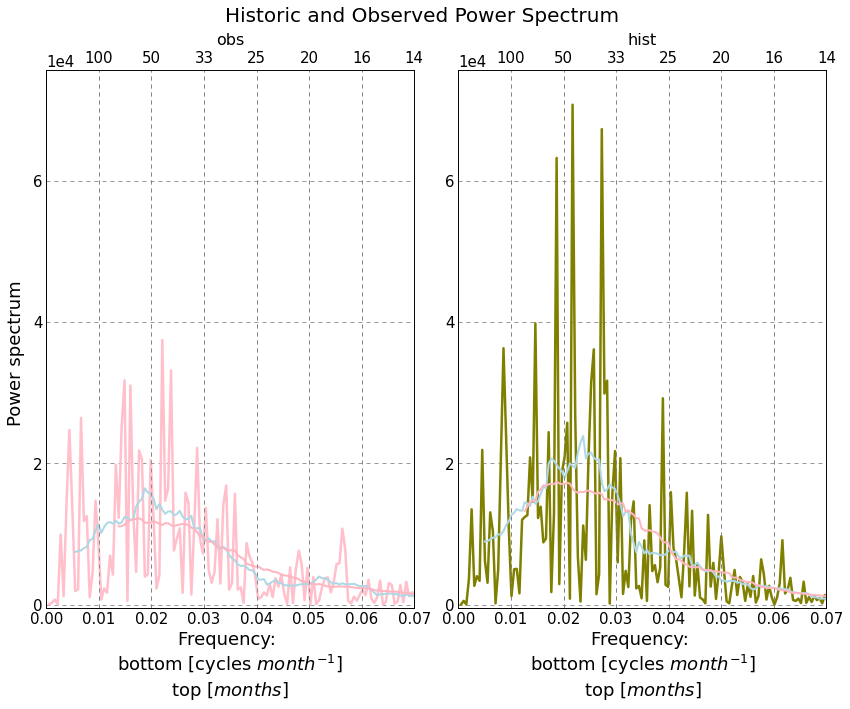

In [30]:
##############################################################################
############################ Power Spectra ###################################
#### (5-Hist+Obs) ####### (SubPlot Line Plot) ################################
##############################################################################

# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(dataset_names[7:])
idx[0] = freqs_hist > 0
idx[1] = freqs_obs > 0
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
# Add a supplementary x-axes
twin1 = axs[0].twiny()
twin2 = axs[1].twiny()
for i, dataset in enumerate(dataset_names):
   if dataset in ['obs']:
      # Plot y versus x as lines in the Axes
      axs[0].plot(freqs_obs[idx[1]], power_spec_obs[idx[1]], color=colors[i], linewidth = 2.5, label='obs')
      #ps_low = ctl.butter_filter(ps, 20)
      ps_low = ctl.running_mean(power_spec_obs, 20)
      axs[0].plot(freqs_obs[idx[1]], ps_low[idx[1]], color='lightblue', linewidth = 2)
      #ps_low = ctl.butter_filter(ps, 50)
      ps_low = ctl.running_mean(power_spec_obs, 50)
      axs[0].plot(freqs_obs[idx[1]], ps_low[idx[1]], color='lightpink', linewidth = 2)
      axs[0].set_title(f'{dataset}', fontsize=16)
      # axs[0, 1].set_ylabel('Power spectrum', fontsize=12)
   elif dataset in ['hist']:
      # Plot y versus x as lines in the Axes
      axs[1].plot(freqs_hist[idx[0]], power_spec_hist[idx[0]], color=colors[i], linewidth = 2.5, label='hist')
      #ps_low = ctl.butterYah!Yu6JYah!Yu6J_filter(ps, 20)
      ps_low = ctl.running_mean(power_spec_hist, 20)
      axs[1].plot(freqs_hist[idx[0]], ps_low[idx[0]], color='lightblue', linewidth = 2)
      #ps_low = ctl.butter_filter(ps, 50)
      ps_low = ctl.running_mean(power_spec_hist, 50)
      axs[1].plot(freqs_hist[idx[0]], ps_low[idx[0]], color='lightpink', linewidth = 2)
      axs[1].set_title(f'{dataset}', fontsize=16)
   
   # if col == 0 and row<4:
   #    axs[row, col].set_ylabel('Power spectrum', fontsize=12)

# Set title and x-y axis labels for the Axes
for ax in axs.flat:
   # Add a legend on the Axes
   # ax.legend(loc = 'upper right')
   # Standardizzazione y-axis limit (fondoscala subplots)
   ax.set_ylim(-500, np.max(power_spec_hist[idx[0]])+(0.07*np.max(power_spec_hist[idx[0]])))
   # Set x-axis limit
   ax.set_xlim(0.0, 0.07)
   ax.xaxis.set_major_formatter('{x:0<3.2f}')
   # Set x-axis ticks
   ax.locator_params(nbins=7)
   # Set title and x-y axis labels for the Axes
   ax.set_xlabel('Frequency: \nbottom [cycles ' r'$month^{-1}]$' '\ntop 'r'$[months]$', fontsize=18)
   # Set the axis notation
   ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
# Remove y-ticks from right axes
# axs[1].set_yticklabels("")

# Twin axes managements
# Reciproco degli assi x principali
reciprocal_ticks = 1 / axs[0].get_xticks()
reciprocal_ticks = np.delete(axs[0].get_xticks(), 0)
# Impostazione dei ticks sull'asse twiny()
twin1.set_xticks(reciprocal_ticks)
twin2.set_xticks(reciprocal_ticks)
twin1.set_xlim(axs[0].get_xlim())  # Usa gli stessi limiti dell'asse principale
twin2.set_xlim(axs[1].get_xlim())
twin1.set_xticklabels(['100', '50', '33', '25', '20', '16', '14']) # [f"{1/x:.1f}" for x in ax.get_xticks()]
twin2.set_xticklabels(['100', '50', '33', '25', '20', '16', '14'])
twin1.grid(linestyle='--', color='gray')
twin2.grid(linestyle='--', color='gray')
#twin1.set_xlabel('Reciprocal Frequency: [months/cycle]', fontsize=14)
fig.suptitle('Historic and Observed Power Spectrum', fontsize=20)
fig.supylabel('Power spectrum', fontsize=18)
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-HistObs_v1.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-HistObs_v1.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

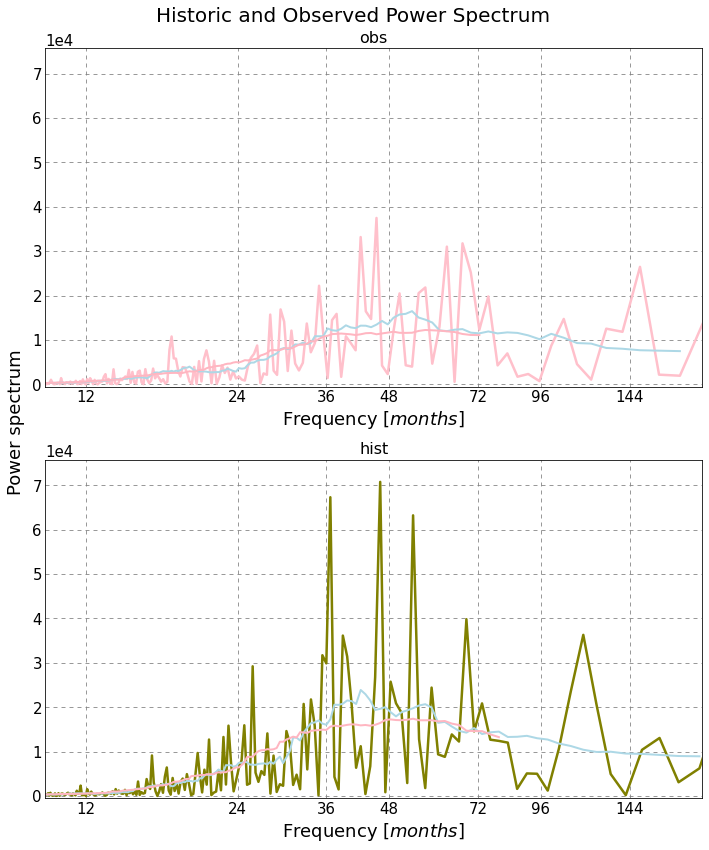

In [25]:
##############################################################################
############################ Power Spectra ###################################
#### (5-Hist+Obs) ####### (SubPlot Line Plot) ################################
##############################################################################

# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(dataset_names[7:])
idx[0] = freqs_hist > 0
idx[1] = freqs_obs > 0


plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
#plt.xscale("log")
for i, dataset in enumerate(dataset_names):
   if dataset in ['obs']:
      # Plot y versus x as lines in the Axes
      axs[0].plot(np.log(1/(freqs_obs[idx[1]])), power_spec_obs[idx[1]], color=colors[i], linewidth = 2.5, label='obs')
      #ps_low = ctl.butter_filter(ps, 20)
      ps_low = ctl.running_mean(power_spec_obs, 20)
      axs[0].plot(np.log(1/(freqs_obs[idx[1]])), ps_low[idx[1]], color='lightblue', linewidth = 2)
      #ps_low = ctl.butter_filter(ps, 50)
      ps_low = ctl.running_mean(power_spec_obs, 50)
      axs[0].plot(np.log(1/(freqs_obs[idx[1]])), ps_low[idx[1]], color='lightpink', linewidth = 2)
      axs[0].set_title(f'{dataset}', fontsize=16)
   elif dataset in ['hist']:
      # Plot y versus x as lines in the Axes
      axs[1].plot(np.log(1/(freqs_hist[idx[0]])), power_spec_hist[idx[0]], color=colors[i], linewidth = 2.5, label='hist')
      #ps_low = ctl.butterYah!Yu6JYah!Yu6J_filter(ps, 20)
      ps_low = ctl.running_mean(power_spec_hist, 20)
      axs[1].plot(np.log(1/(freqs_hist[idx[0]])), ps_low[idx[0]], color='lightblue', linewidth = 2)
      #ps_low = ctl.butter_filter(ps, 50)
      ps_low = ctl.running_mean(power_spec_hist, 50)
      axs[1].plot(np.log(1/(freqs_hist[idx[0]])), ps_low[idx[0]], color='lightpink', linewidth = 2)
      axs[1].set_title(f'{dataset}', fontsize=16)
   
   # if col == 0 and row<4:
   #    axs[row, col].set_ylabel('Power spectrum', fontsize=12)

# Set title and x-y axis labels for the Axes
for ax in axs.flat:
   # Add a legend on the Axes
   # ax.legend(loc = 'upper right')
   # Standardizzazione y-axis limit (fondoscala subplots)
   ax.set_ylim(-500, np.max(power_spec_hist[idx[0]])+(0.07*np.max(power_spec_hist[idx[0]])))
   # Set x-axis ticks and labels
   ax.set_xticks(np.log([12,24,36,48,72,96,144])) #np.geomspace(12, 192, num=10, endpoint=True, dtype=int)
   ax.set_xticklabels(('12', '24', '36', '48', '72', '96', '144'))
   #ax.locator_params(nbins=6)
   # Set x-axis limit
   ax.set_xlim(2.3, 5.3)
   # Convert x-axis to Logarithmic scale
   #ax.set_xscale("log")
   # Set title and x-y axis labels for the Axes
   ax.set_xlabel('Frequency ' r'$[months]$', fontsize=18)
   # Set the axis notation
   ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
fig.suptitle('Historic and Observed Power Spectrum', fontsize=20)
fig.supylabel('Power spectrum', fontsize=18)
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-HistObs_v2.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-HistObs_v2.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

In [ ]:
""" uniformo il range a quello del pi a 150 mesi? ci sono dei picchi importanti fino appuntio ai 200 però hanno pochi punti e la media a 20 e soprattutto a 50 non ci arriva, si fermano a 72 mesi """

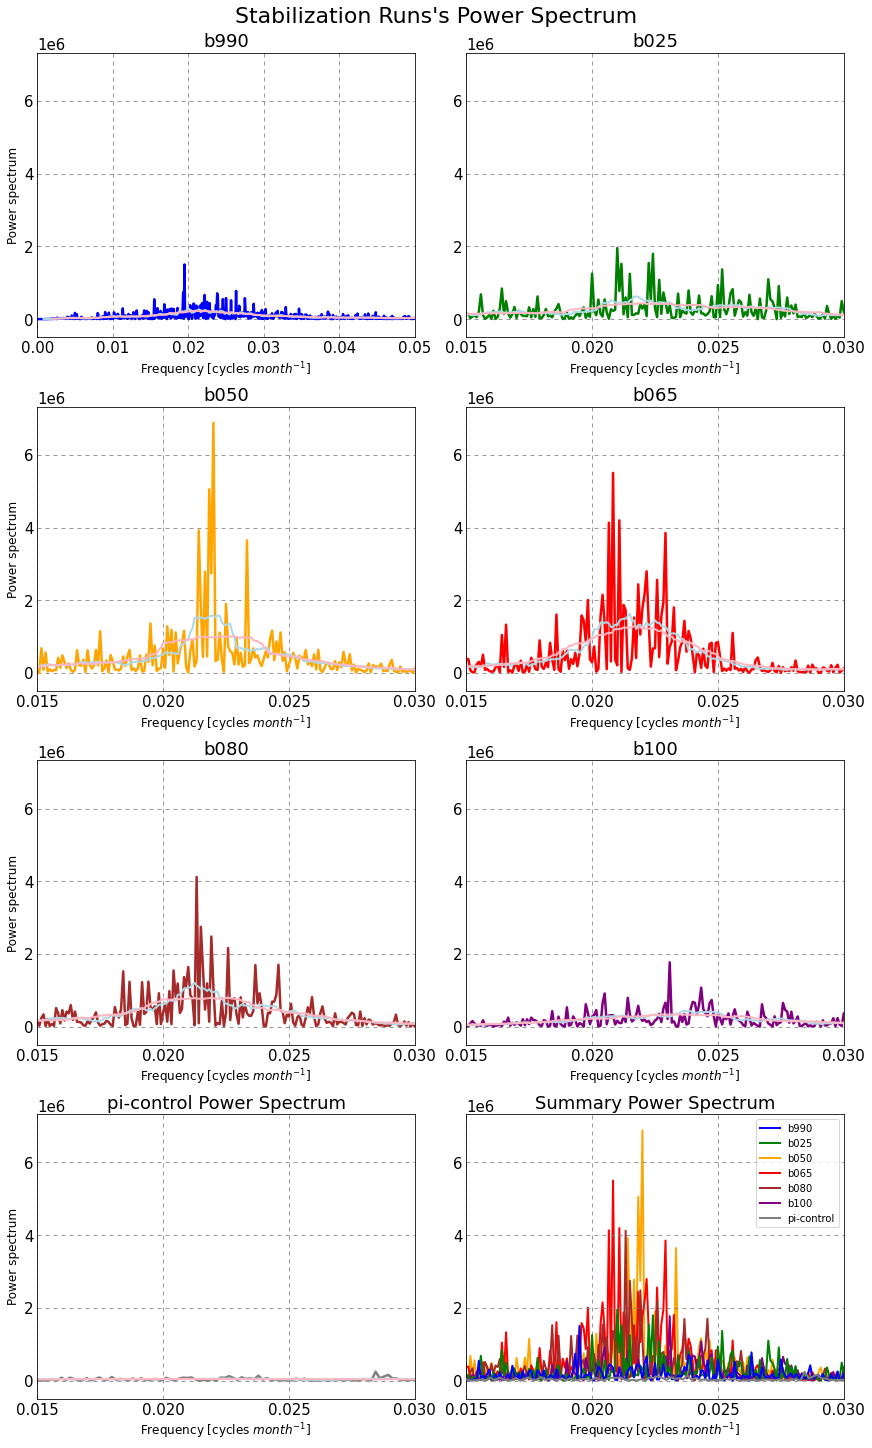

In [ ]:
##############################################################################
############################ Power Spectra ###################################
######## (5.3) ########## (SubPlot Line Plot) ################################
##############################################################################
# Ordine di sovrapposizione nel plot omnicomprensivo
zorder = [3.0,2.5,2.0,0,0.5,1.0,1.5]
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(zorder)
for i in range(len(zorder)):
   if i<(len(zorder)-1):
      idx[i]=freqs[i] > 0
   else:
      idx[i]=freqs_pi > 0
#idx = np.roll(idx, 1) #Faccio slittare tutto di 1 in avanti per causa del pi-control che non fa parte della stessa variaile degli altri bottini
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,20), layout='constrained')
for i, dataset in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   if dataset not in ['pi-control', 'hist', 'obs']:
      # Plot y versus x as lines in the Axes
      axs[row, col].plot(freqs[i][idx[i]], power_spec[i][idx[i]], color=colors[i], linewidth = 2.5)
      #ps_low = ctl.butter_filter(ps, 20)
      ps_low = ctl.running_mean(power_spec[i], 20)
      axs[row, col].plot(freqs[i][idx[i]], ps_low[idx[i]], color='lightblue', linewidth = 2)
      #ps_low = ctl.butter_filter(ps, 50)
      ps_low = ctl.running_mean(power_spec[i], 50)
      axs[row, col].plot(freqs[i][idx[i]], ps_low[idx[i]], color='lightpink', linewidth = 2)
      axs[row, col].set_title(f'{dataset}', fontsize=18)
      # Plot collettivo
      axs[3, 1].plot(freqs[i][idx[i]], power_spec[i][idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
   elif dataset in ['pi-control']:
      # Plot y versus x as lines in the Axes
      axs[row, col].plot(freqs_pi[idx[i]], power_spec_pi[idx[i]], color=colors[i], linewidth = 2.5)
      ps_low = ctl.running_mean(power_spec_pi, 20)
      axs[row, col].plot(freqs_pi[idx[i]], ps_low[idx[i]], color='lightblue', linewidth = 2)
      ps_low = ctl.running_mean(power_spec_pi, 50)
      axs[row, col].plot(freqs_pi[idx[i]], ps_low[idx[i]], color='lightpink', linewidth = 2)
      axs[row, col].set_title(f'{dataset} Power Spectrum', fontsize=18)
      axs[row, col].set_ylabel('Power spectrum', fontsize=12)
      # Plot collettivo
      axs[3, 1].plot(freqs_pi[idx[i]], power_spec_pi[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)
      # Add a legend on the Axes
      axs[3, 1].legend(loc = 'upper right')
      axs[3, 1].set_title('Summary Power Spectrum', fontsize=18)
   
   if col == 0 and row<4:
      axs[row, col].set_ylabel('Power spectrum', fontsize=12)

# Set title and x-y axis labels for the Axes
for ax in axs.flat:
   # Set x & y-axis limit
   ax.set_xlim(0.015, 0.03)
   # Standardizzazione fondoscala subplots
   ax.set_ylim(-500000, np.max(power_spec[2][idx[2]])+(0.065*np.max(power_spec[2][idx[2]]))) # aggiungo il 6.5% al massimo così non va a fondoscala
   # Set x-axis ticks
   ax.locator_params(nbins=5)
   # Set title and x-y axis labels for the Axes
   ax.set_xlabel('Frequency [cycles ' r'$month^{-1}]$', fontsize=12)
   #ax.set_ylabel('Power spectrum', fontsize=12)
   # Set the axis notation
   ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
axs[0,0].set_xlim(0.0, 0.05)
fig.suptitle('Stabilization Runs\'s Power Spectrum', fontsize=22)
#fig.supylabel('Power spectrum', fontsize=14)
#plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra_v3.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra_v3.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

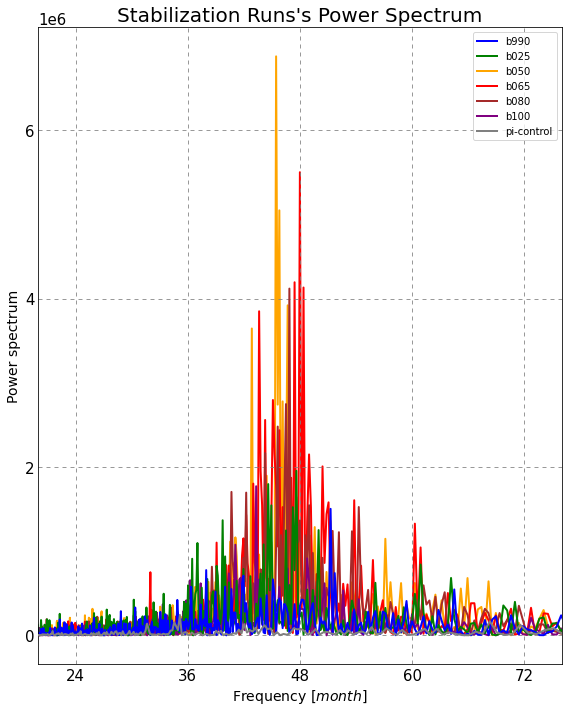

In [ ]:
###################################################################################
################################## Power Spectra ##################################
######## (5.4) ################# (Multi-Line Plot) ################################
###################################################################################
# Ordine di sovrapposizione nel plot omnicomprensivo
zorder = [3.0,2.5,2.0,0,0.5,1.0,1.5]
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(zorder)
for i in range(len(zorder)):
   if i<(len(zorder)-1):
      idx[i]=freqs[i] > 0
   else:
      idx[i]=freqs_pi > 0

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(8, 10))
for i, dataset in enumerate(dataset_names):
   if dataset not in ['pi-control', 'hist', 'obs']:
      # Plot y versus x as lines in the Axes
      ax.plot(1/(freqs[i][idx[i]]), power_spec[i][idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
   elif dataset in ['pi-control']:
      # Plot y versus x as lines in the Axes
      ax.plot(1/(freqs_pi[idx[i]]), power_spec_pi[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)
# Add a legend on the Axes
ax.legend(loc = 'upper right')
# Set x-axis limit
ax.set_xlim(20, 76)
ax.set_xticks(x_ticks_ps)
ax.set_xticklabels(x_labels_ps)
# Set x-axis ticks
ax.locator_params(nbins=5)
# Set title and x-y axis labels for the Axes
ax.set_title('Stabilization Runs\'s Power Spectrum', fontsize=20)
ax.set_xlabel('Frequency ' r'$[month]$', fontsize=14)
ax.set_ylabel('Power spectrum', fontsize=14)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
#fig.supylabel('Power spectrum', fontsize=14)
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra_v4.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra_v4.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

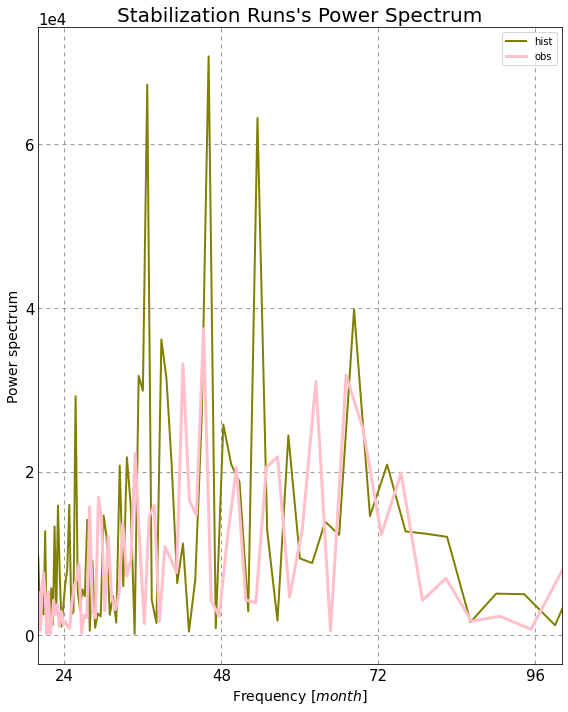

In [ ]:
###################################################################################
################################## Power Spectra ##################################
######## (5.4) ################# (Multi-Line Plot) ################################
###################################################################################
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(dataset_names[7:])
idx[0] = freqs_hist > 0
idx[1] = freqs_obs > 0

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(8, 10))
for i, dataset in enumerate(dataset_names):
   if dataset in ['hist']:
      # Plot y versus x as lines in the Axes
      ax.plot(1/(freqs_hist[idx[0]]), power_spec_hist[idx[0]], color=colors[i], linewidth = 2, label='hist')
   elif dataset in ['obs']:
      # Plot y versus x as lines in the Axes
      ax.plot(1/(freqs_obs[idx[1]]), power_spec_obs[idx[1]], color=colors[i], linewidth = 3, label='obs')
# Add a legend on the Axes
ax.legend(loc = 'upper right')
# Set x-axis limit
ax.set_xlim(20, 100)
ax.set_xticks(x_ticks_ps_ext)
ax.set_xticklabels(x_labels_ps_ext)
# Set the axis notation
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# Set x-axis ticks
ax.locator_params(nbins=6)
# Set title and x-y axis labels for the Axes
ax.set_title('Stabilization Runs\'s Power Spectrum', fontsize=20)
ax.set_xlabel('Frequency ' r'$[month]$', fontsize=14)
ax.set_ylabel('Power spectrum', fontsize=14)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
#fig.supylabel('Power spectrum', fontsize=14)
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-HistObs_v4.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-HistObs_v4.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

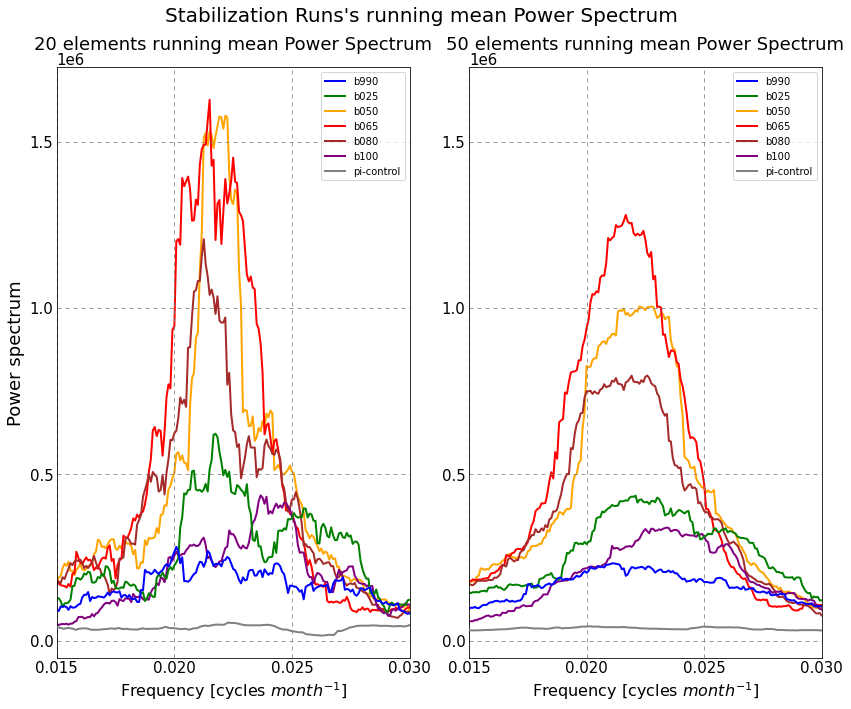

In [ ]:
###################################################################################
################################## Power Spectra ##################################
######## (5.5) ################ (RM Multi-Line Plot) ##############################
###################################################################################
# Ordine di sovrapposizione nel plot omnicomprensivo
zorder = [3.0,2.5,2.0,0,0.5,1.0,1.5]
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(zorder)
for i in range(len(zorder)):
   if i<(len(zorder)-1):
      idx[i]=freqs[i] > 0
   else:
      idx[i]=freqs_pi > 0

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
for i, dataset in enumerate(dataset_names):
   if dataset not in ['pi-control', 'hist', 'obs']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec[i], 20)
      axs[0].plot(freqs[i][idx[i]], ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
      ps_low = ctl.running_mean(power_spec[i], 50)
      axs[1].plot(freqs[i][idx[i]], ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
   elif dataset in ['pi-control']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec_pi, 20)
      axs[0].plot(freqs_pi[idx[i]], ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)
      ps_low = ctl.running_mean(power_spec_pi, 50)
      axs[1].plot(freqs_pi[idx[i]], ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)

axs[0].set_title('20 elements running mean Power Spectrum', y=1.02, fontsize=18)
axs[1].set_title('50 elements running mean Power Spectrum', y=1.02, fontsize=18)

for ax in axs.flat:
   # Add a legend on the Axes
   ax.legend(loc = 'upper right')
   # Set x & y axis limit
   ax.set_xlim(0.015, 0.03)
   ax.set_ylim(-50000, np.nanmax((ctl.running_mean(power_spec[3], 20))+(0.06*ctl.running_mean(power_spec[3], 20))))
   # Set x-axis ticks
   ax.locator_params(nbins=5)
   # Set y axis labels for the Axes
   ax.set_xlabel('Frequency [cycles ' r'$month^{-1}]$', fontsize=16)
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
fig.suptitle('Stabilization Runs\'s running mean Power Spectrum', fontsize=20)
fig.supylabel('Power spectrum', fontsize=18)
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM_v5.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM_v5.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

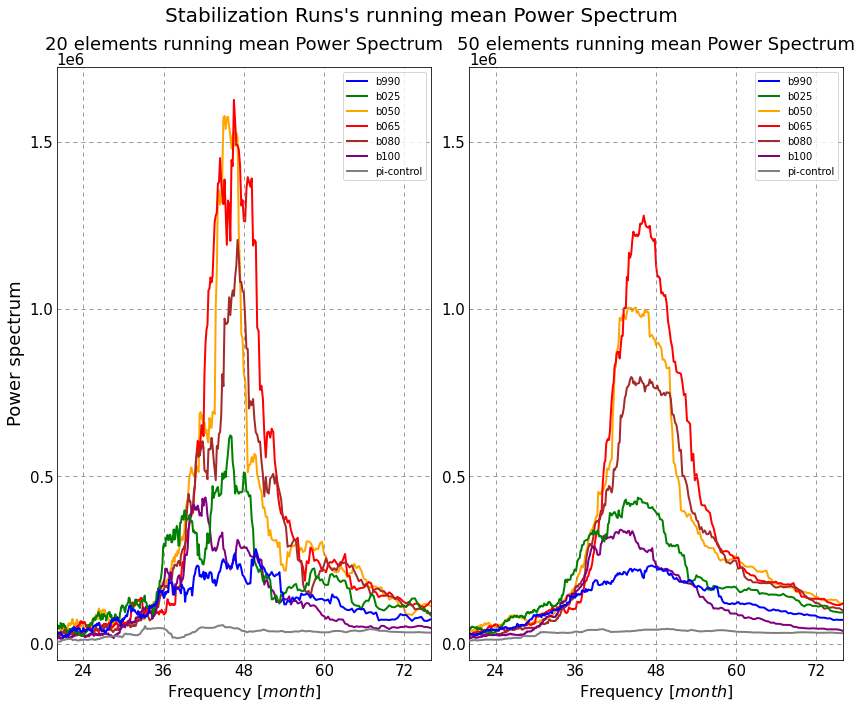

In [ ]:
###################################################################################
################################## Power Spectra ##################################
######## (5.6) ################ (RM Multi-Line Plot) ##############################
###################################################################################
# Ordine di sovrapposizione nel plot omnicomprensivo
zorder = [3.0,2.5,2.0,0,0.5,1.0,1.5]
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(zorder)
for i in range(len(zorder)):
   if i<(len(zorder)-1):
      idx[i]=freqs[i] > 0
   else:
      idx[i]=freqs_pi > 0

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
for i, dataset in enumerate(dataset_names):
   if dataset not in ['pi-control', 'hist', 'obs']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec[i], 20)
      axs[0].plot(1/(freqs[i][idx[i]]), ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
      ps_low = ctl.running_mean(power_spec[i], 50)
      axs[1].plot(1/(freqs[i][idx[i]]), ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
   elif dataset in ['pi-control']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec_pi, 20)
      axs[0].plot(1/(freqs_pi[idx[i]]), ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)
      ps_low = ctl.running_mean(power_spec_pi, 50)
      axs[1].plot(1/(freqs_pi[idx[i]]), ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)

axs[0].set_title('20 elements running mean Power Spectrum', y=1.02, fontsize=18)
axs[1].set_title('50 elements running mean Power Spectrum', y=1.02, fontsize=18)

for ax in axs.flat:
   # Add a legend on the Axes
   ax.legend(loc = 'upper right')
   # Set x & y axis limit
   ax.set_xlim(20, 76)
   ax.set_ylim(-50000, np.nanmax((ctl.running_mean(power_spec[3], 20))+(0.06*ctl.running_mean(power_spec[3], 20))))
   # Set x-axis ticks
   ax.set_xticks(x_ticks_ps)
   ax.set_xticklabels(x_labels_ps)
   ax.locator_params(nbins=5)
   # Set y axis labels for the Axes
   ax.set_xlabel('Frequency ' r'$[month]$', fontsize=16)
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
fig.suptitle('Stabilization Runs\'s running mean Power Spectrum', fontsize=20)
fig.supylabel('Power spectrum', fontsize=18)
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM_v6.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM_v6.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

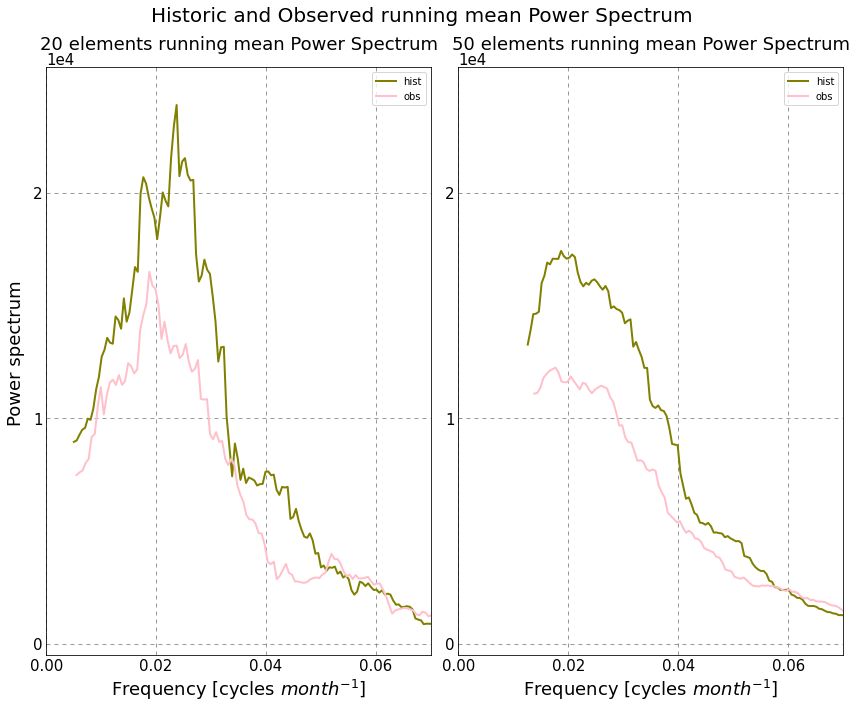

In [ ]:
###################################################################################
################################## Power Spectra ##################################
##### (5-tris-HistObs) #### (RM Multi-Line Plot) ##############################
###################################################################################
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(dataset_names[7:])
idx[0] = freqs_hist > 0
idx[1] = freqs_obs > 0
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
for i, dataset in enumerate(dataset_names):
   if dataset in ['hist']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec_hist, 20)
      axs[0].plot(freqs_hist[idx[0]], ps_low[idx[0]], color=colors[i], label=dataset, linewidth = 2)
      ps_low = ctl.running_mean(power_spec_hist, 50)
      axs[1].plot(freqs_hist[idx[0]], ps_low[idx[0]], color=colors[i], label=dataset, linewidth = 2)
   elif dataset in ['obs']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec_obs, 20)
      axs[0].plot(freqs_obs[idx[1]], ps_low[idx[1]], color=colors[i], label=dataset, linewidth = 2)
      ps_low = ctl.running_mean(power_spec_obs, 50)
      axs[1].plot(freqs_obs[idx[1]], ps_low[idx[1]], color=colors[i], label=dataset, linewidth = 2)

axs[0].set_title('20 elements running mean Power Spectrum', y=1.02, fontsize=18)
axs[1].set_title('50 elements running mean Power Spectrum', y=1.02, fontsize=18)

for ax in axs.flat:
   # Add a legend on the Axes
   ax.legend(loc = 'upper right')
   # Set x & y axis limit
   #ax.set_xlim(0., 0.1)
   ax.xaxis.set_major_formatter('{x:0<3.2f}')
   ax.set_ylim(-500, np.nanmax(ctl.running_mean(power_spec_hist, 20))+(0.07*np.nanmax(ctl.running_mean(power_spec_hist, 20))))
   # Set x-axis limit
   ax.set_xlim(0.0, 0.07)
   # Set x-axis ticks numbers
   ax.locator_params(nbins=5)
   # Set y axis labels for the Axes
   ax.set_xlabel('Frequency [cycles ' r'$month^{-1}]$', fontsize=18)
   ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
fig.suptitle('Historic and Observed running mean Power Spectrum', fontsize=20)
fig.supylabel('Power spectrum', fontsize=18)
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM-HistObs_v3.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM-HistObs_v3.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

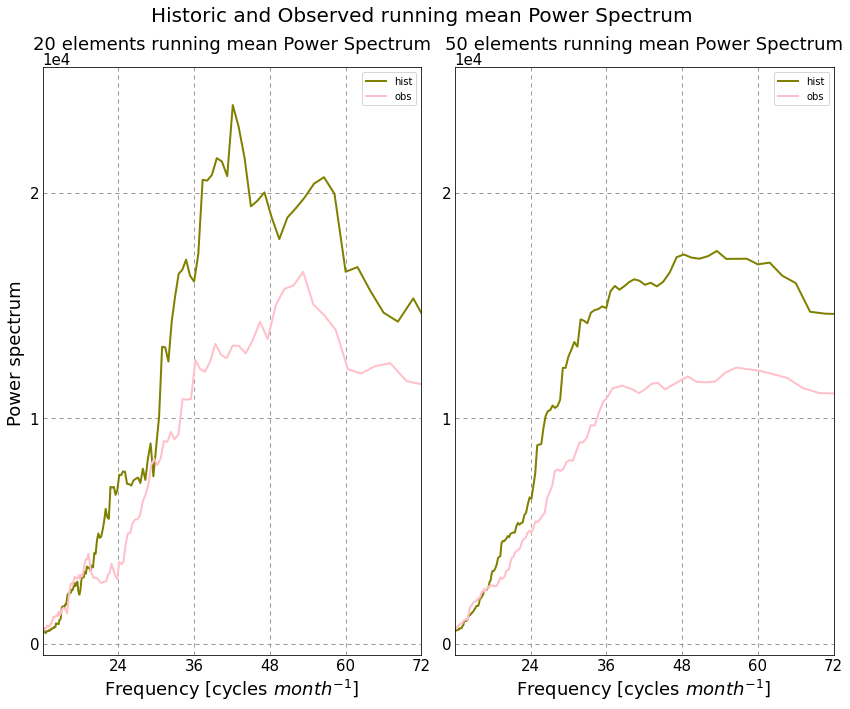

In [ ]:
###################################################################################
################################## Power Spectra ##################################
##### (5-quadris-HistObs) #### (RM Multi-Line Plot) ##############################
###################################################################################
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(dataset_names[7:])
idx[0] = freqs_hist > 0
idx[1] = freqs_obs > 0
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
for i, dataset in enumerate(dataset_names):
   if dataset in ['hist']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec_hist, 20)
      axs[0].plot(1/(freqs_hist[idx[0]]), ps_low[idx[0]], color=colors[i], label=dataset, linewidth = 2)
      ps_low = ctl.running_mean(power_spec_hist, 50)
      axs[1].plot(1/(freqs_hist[idx[0]]), ps_low[idx[0]], color=colors[i], label=dataset, linewidth = 2)
   elif dataset in ['obs']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec_obs, 20)
      axs[0].plot(1/(freqs_obs[idx[1]]), ps_low[idx[1]], color=colors[i], label=dataset, linewidth = 2)
      ps_low = ctl.running_mean(power_spec_obs, 50)
      axs[1].plot(1/(freqs_obs[idx[1]]), ps_low[idx[1]], color=colors[i], label=dataset, linewidth = 2)

axs[0].set_title('20 elements running mean Power Spectrum', y=1.02, fontsize=18)
axs[1].set_title('50 elements running mean Power Spectrum', y=1.02, fontsize=18)

for ax in axs.flat:
   # Add a legend on the Axes
   ax.legend(loc = 'upper right')
   # Set x & y axis limit

   ax.set_ylim(-500, np.nanmax(ctl.running_mean(power_spec_hist, 20))+(0.07*np.nanmax(ctl.running_mean(power_spec_hist, 20))))
   ax.set_xlim(12, 72)
   # Set x-axis ticks
   ax.set_xticks(x_ticks_ps)
   ax.set_xticklabels(x_labels_ps)
   ax.locator_params(nbins=5)
   # Set y axis labels for the Axes
   ax.set_xlabel('Frequency [cycles ' r'$month^{-1}]$', fontsize=18)
   ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
fig.suptitle('Historic and Observed running mean Power Spectrum', fontsize=20)
fig.supylabel('Power spectrum', fontsize=18)
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM-HistObs_v4.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM-HistObs_v4.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

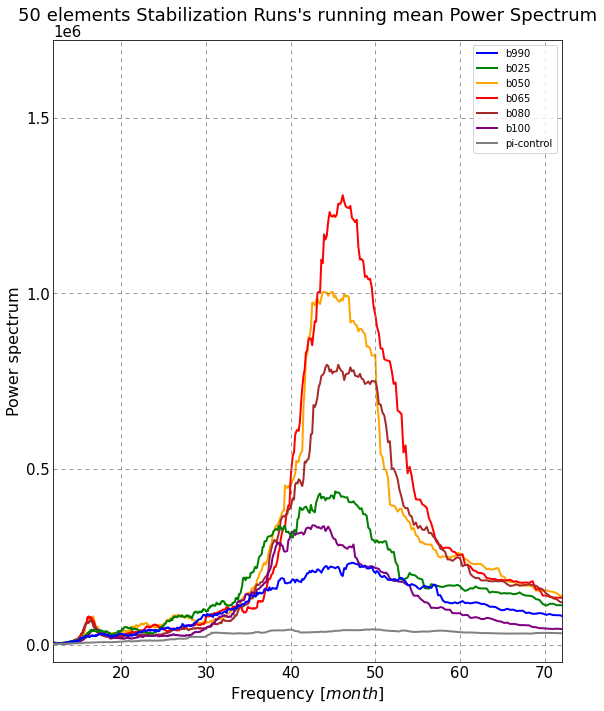

In [ ]:
###################################################################################
################################## Power Spectra ##################################
###### (5-quadris-HistObs) #### (RM Multi-Line Plot) ##############################
###################################################################################
# Ordine di sovrapposizione nel plot omnicomprensivo
zorder = [3.0,2.5,2.0,0,0.5,1.0,1.5]
# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(zorder)
for i in range(len(zorder)):
   if i<(len(zorder)-1):
      idx[i]=freqs[i] > 0
   else:
      idx[i]=freqs_pi > 0

plt.style.use('_mpl-gallery')
# Ninõ Index_Year plot
fig, ax = plt.subplots(figsize=(8, 10))
for i, dataset in enumerate(dataset_names):
   if dataset not in ['pi-control', 'hist', 'obs']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec[i], 50)
      ax.plot(1/(freqs[i][idx[i]]), ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[i+1], linewidth = 2)
   elif dataset in ['pi-control']:
      # Plot y versus x as lines in the Axes
      ps_low = ctl.running_mean(power_spec_pi, 50)
      ax.plot(1/(freqs_pi[idx[i]]), ps_low[idx[i]], color=colors[i], label=dataset, zorder=zorder[0], linewidth = 2)

ax.set_title('50 elements Stabilization Runs\'s running mean Power Spectrum', y=1.02, fontsize=18)

# Add a legend on the Axes
ax.legend(loc = 'upper right')
# Set x & y axis limit
ax.set_xlim(12, 72)
ax.set_ylim(-50000, np.nanmax((ctl.running_mean(power_spec[3], 20))+(0.06*ctl.running_mean(power_spec[3], 20))))
# Set x-axis ticks
ax.locator_params(nbins=6)
# Set y axis labels for the Axes
ax.set_xlabel('Frequency ' r'$[month]$', fontsize=16)
ax.set_ylabel('Power spectrum', fontsize=16)
# Adds gridlines to the Axes
ax.grid(linestyle='--', color='gray')
plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM-Extended_v7.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'PowerSpectra-RM-Extended_v7.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

In [ ]:
""" Statistiche """

In [14]:
####################### Massimi del Power Spectra ##########################

# Parametri 
cost = 0.005  # La distanza in freq tra i punti
n = 5  # Numero di valori massimi da selezionare

# Inizializzo 3 liste per memorizzare gli indici dei valori massimi che soddisfano la condizione di distanza cost
selected_indices, selected_values, selected_freqs = [[[] for _ in range(len(dataset_names))] for _ in range(3)]

# Maschera per plottare solamente la parte positiva dello spettro (che sta nello spazio delle fasi)
idx = [None]*len(dataset_names)
ps_rm, ps_max = [[None]*len(dataset_names)  for _ in range(2)]
# Calcolo dei massimi dei datasets
for i, dataset in enumerate(dataset_names):

    if dataset not in ['pi-control', 'hist', 'obs']:
        idx[i] = freqs[i] > 0
        ps_rm[i] = ctl.running_mean(power_spec[i][idx[i]], 50)
        ps_max[i] = np.nanargmax(ps_rm[i])
        # Ottenere gli indici dei valori crescenti del power_spec[idx[]]
        sorted_indices = np.argsort(power_spec[i][idx[i]])[::-1]
        #print(dataset, ps_rm, ps_max, ps_rm[ps_max])
    elif dataset in ['pi-control']:
        idx[i] = freqs_pi > 0
        ps_rm[i] = ctl.running_mean(power_spec_pi[idx[i]], 50)
        ps_max[i] = np.nanargmax(ps_rm[i])
        sorted_indices = np.argsort(power_spec_pi[idx[i]])[::-1]
    elif dataset in ['hist']:
        idx[i] = freqs_hist > 0
        ps_rm[i] = ctl.running_mean(power_spec_hist[idx[i]], 50)
        ps_max[i] = np.nanargmax(ps_rm[i])
        sorted_indices = np.argsort(power_spec_hist[idx[i]])[::-1]
    elif dataset in ['obs']:
        idx[i] = freqs_obs > 0
        ps_rm[i] = ctl.running_mean(power_spec_obs[idx[i]], 50)
        ps_max[i] = np.nanargmax(ps_rm[i])
        sorted_indices = np.argsort(power_spec_obs[idx[i]])[::-1]
    
    for j in sorted_indices:
        if len(selected_indices[i]) >= n:
            break
        if len(selected_indices[i]) == 0:
            selected_indices[i].append(j)
        else:
            if dataset not in ['pi-control', 'hist', 'obs']:
                # Calcolo delle differenze di frequenza per gli indici già selezionati
                valid_differences = [abs(freqs[i][idx[i]][j] - freqs[i][idx[i]][k]) >= cost 
                                     for k in selected_indices[i]]
                if all(valid_differences):
                    selected_indices[i].append(j)
            elif dataset in ['pi-control']:
                # altro metodo con verifica più compatto e leggero ma meno semplice da leggere e debuggare
                assert all(isinstance(k, (int, np.integer)) for k in selected_indices[i]), "selected_indices contains non-integer values!"
                if all(abs(freqs_pi[idx[i]][j] - freqs_pi[idx[i]][k]) >= cost for k in selected_indices[i]):
                    selected_indices[i].append(j)
            elif dataset in ['hist']:
                if all(abs(freqs_hist[idx[i]][j] - freqs_hist[idx[i]][k]) >= cost for k in selected_indices[i]):
                    selected_indices[i].append(j)
            elif dataset in ['obs']:
                if all(abs(freqs_obs[idx[i]][j] - freqs_obs[idx[i]][k]) >= cost for k in selected_indices[i]):
                    selected_indices[i].append(j)


# Stampaggio dei risultati
for i, dataset in enumerate(dataset_names):
    if dataset not in ['pi-control', 'hist', 'obs']:
        for j in selected_indices[i]:
            print(
                dataset,
                "freqs: ", freqs[i][idx[i]][j].round(3),
                "in mesi: ", (1/freqs[i][idx[i]][j]).round(1),
                "in anni: ", (1/freqs[i][idx[i]][j]/12).round(1),
                "power_spec: ", int(power_spec[i][idx[i]][j]),
                )
        print(
            "-------------------------------------\n",
            "power_spec rm 50 element: ", int(ps_rm[i][ps_max[i]]),
            " freqs equivalente: ",  freqs[i][idx[i]][ps_max[i]].round(3), (1/freqs[i][idx[i]][ps_max[i]]).round(1), (1/freqs[i][idx[i]][ps_max[i]]/12).round(1),
            "\n-------------------------------------\n"
        )
    elif dataset in ['pi-control']:
        for j in selected_indices[i]:
            print(
                dataset,
                "freqs: ", freqs_pi[idx[i]][j].round(3),
                "in mesi: ", (1/freqs_pi[idx[i]][j]).round(1),
                "in anni: ", (1/freqs_pi[idx[i]][j]/12).round(1),
                "power_spec: ", int(power_spec_pi[idx[i]][j])
                )
        print(
            "-------------------------------------\n",
            "power_spec rm 50 element: ", int(ps_rm[i][ps_max[i]]),
            "freqs equivalente: ",  freqs_pi[idx[i]][ps_max[i]].round(3), (1/freqs_pi[idx[i]][ps_max[i]]).round(1), (1/freqs_pi[idx[i]][ps_max[i]]/12).round(1),
            "\n-------------------------------------\n"
        )
    elif dataset in ['hist']:
        for j in selected_indices[i]:
            print(
                dataset,
                "freqs: ", freqs_hist[idx[i]][j].round(3),
                "in mesi: ", (1/freqs_hist[idx[i]][j]).round(1),
                "in anni: ", (1/freqs_hist[idx[i]][j]/12).round(1),
                "power_spec: ", int(power_spec_hist[idx[i]][j])
                )
        print(
            "-------------------------------------\n",
            "power_spec rm 50 element: ", int(ps_rm[i][ps_max[i]]),
            "freqs equivalente: ",  freqs_hist[idx[i]][ps_max[i]].round(3), (1/freqs_hist[idx[i]][ps_max[i]]).round(1), (1/freqs_hist[idx[i]][ps_max[i]]/12).round(1),
            "\n-------------------------------------\n"
        )       
    elif dataset in ['obs']:
        for j in selected_indices[i]:
            print(
                dataset,
                "freqs: ", freqs_obs[idx[i]][j].round(3),
                "in mesi: ", (1/freqs_obs[idx[i]][j]).round(1),
                "in anni: ", (1/freqs_obs[idx[i]][j]/12).round(1),
                "power_spec: ", int(power_spec_obs[idx[i]][j])
                )
        print(
            "-------------------------------------\n",
            "power_spec rm 50 element: ", int(ps_rm[i][ps_max[i]]),
            "freqs equivalente: ",  freqs_obs[idx[i]][ps_max[i]].round(3), (1/freqs_obs[idx[i]][ps_max[i]]).round(1), (1/freqs_obs[idx[i]][ps_max[i]]/12).round(1),
            "\n-------------------------------------\n"
        )

b990 freqs:  0.02 in mesi:  51.3 in anni:  4.3 power_spec:  1503067
b990 freqs:  0.026 in mesi:  38.0 in anni:  3.2 power_spec:  774954
b990 freqs:  0.033 in mesi:  30.4 in anni:  2.5 power_spec:  330845
b990 freqs:  0.011 in mesi:  88.2 in anni:  7.4 power_spec:  295632
b990 freqs:  0.038 in mesi:  26.0 in anni:  2.2 power_spec:  206926
-------------------------------------
 power_spec rm 50 element:  233230  freqs equivalente:  0.021 47.2 3.9 
-------------------------------------

b025 freqs:  0.021 in mesi:  47.6 in anni:  4.0 power_spec:  1955289
b025 freqs:  0.027 in mesi:  37.0 in anni:  3.1 power_spec:  1096730
b025 freqs:  0.016 in mesi:  64.2 in anni:  5.3 power_spec:  681715
b025 freqs:  0.033 in mesi:  30.2 in anni:  2.5 power_spec:  423662
b025 freqs:  0.01 in mesi:  103.4 in anni:  8.6 power_spec:  318568
-------------------------------------
 power_spec rm 50 element:  436538  freqs equivalente:  0.022 45.3 3.8 
-------------------------------------

b050 freqs:  0.022 i